In [1]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics
import logging
import warnings

# Suppress cmdstanpy logs (used by Prophet internally)
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)

# Suppress Prophet "seasonality" and future warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# By Orders

In [2]:
df_o = pd.read_csv('Dataset/top8_coffee_orders_by_column.csv')

In [3]:
df_o['datetime'] = pd.to_datetime(df_o['datetime'])

In [4]:
df_o = df_o.resample('D', on='datetime').sum().reset_index()

In [5]:
df_o.head()

datetime  americano  americano with milk  cappuccino  cocoa  cortado  \
0 2024-03-01          1                    4           0      1        0   
1 2024-03-02          3                    3           0      0        0   
2 2024-03-03          1                    2           0      1        2   
3 2024-03-04          0                    1           0      0        0   
4 2024-03-05          0                    0           0      1        1   

   espresso  hot chocolate  latte  
0         0              3      2  
1         0              0      1  
2         0              2      2  
3         1              0      2  
4         0              4      3

In [6]:
# List of coffee types (excluding datetime)
coffee_types_o = ['americano', 'americano with milk', 'cappuccino', 'cocoa', 'cortado',
                'espresso', 'hot chocolate', 'latte']

# Dictionary to store the individual DataFrames
coffee_dfs_o = {}

# Create one DataFrame per coffee type
for coffee in coffee_types_o:
    coffee_dfs_o[coffee] = df_o[['datetime', coffee]].copy()

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## General

In [8]:
df_general_o = df_o.copy()
df_general_o['y'] = df_general_o[coffee_types_o].sum(axis=1)

In [9]:
df_general_o = df_general_o.rename(columns={'datetime': 'ds', 'y': 'y'})
df_general_o = df_general_o[['ds', 'y']]

17:48:11 - cmdstanpy - INFO - Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 4.80
Daily Prophet RMSE: 5.99
Daily Prophet MAPE: 26.89%


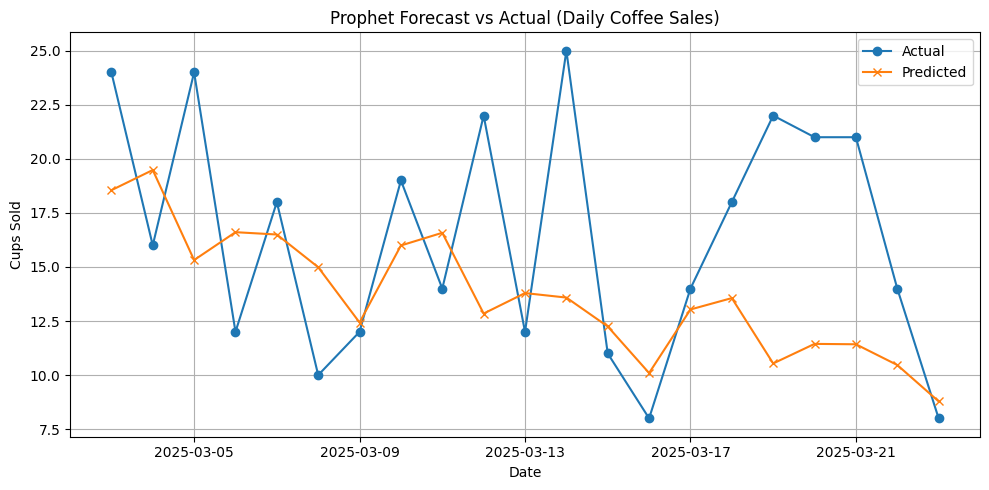

In [10]:
# Step 1: Log transform
df_general_o['y'] = np.log1p(df_general_o['y'])

# Step 2: Split into train/test (last 7 days)
train_df = df_general_o[:-21]
test_df = df_general_o[-21:]

# Step 3: Train the model
model = Prophet(
    daily_seasonality=True,         # Now relevant for daily data
    weekly_seasonality=True,
    yearly_seasonality=True
)
model.add_country_holidays(country_name='MY')
model.fit(train_df)

# Step 4: Create future DataFrame for next 2 days
future = model.make_future_dataframe(periods=21, freq='D')

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Inverse transform and clip
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)

# Step 7: Evaluation on test set
forecast_test = forecast[-21:].copy()
y_true = np.expm1(test_df['y'].values)
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Daily Prophet MAE: {mae:.2f}")
print(f"Daily Prophet RMSE: {rmse:.2f}")
print(f"Daily Prophet MAPE: {mape:.2f}%")

# Step 8: Plot
plt.figure(figsize=(10, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Cups Sold")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Tuning

In [11]:
df_general_o = df_o.copy()
df_general_o['y'] = df_general_o[coffee_types_o].sum(axis=1)

In [12]:
df_general_o = df_general_o.rename(columns={'datetime': 'ds', 'y': 'y'})
df_general_o = df_general_o[['ds', 'y']]

Training: changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=5.0


17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=15.0


17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=1.0


17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=5.0


17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=10.0


17:48:46 - cmdstanpy - INFO - Chain [1] start processing
17:48:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=15.0


17:48:51 - cmdstanpy - INFO - Chain [1] start processing
17:48:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=5.0


17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


17:49:09 - cmdstanpy - INFO - Chain [1] start processing
17:49:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=15.0


17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=1.0


17:49:21 - cmdstanpy - INFO - Chain [1] start processing
17:49:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=5.0


17:49:27 - cmdstanpy - INFO - Chain [1] start processing
17:49:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=10.0


17:49:33 - cmdstanpy - INFO - Chain [1] start processing
17:49:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=15.0


17:49:38 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Best Parameters:
changepoint_prior_scale     0.100000
seasonality_prior_scale    15.000000
mae                         0.298831
rmse                        0.325749
mape                        0.112362
Name: 11, dtype: float64


17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing



Final Test MAE (best model): 5.20
Final Test RMSE (best model): 6.82
Final Test MAPE (best model): 27.16%


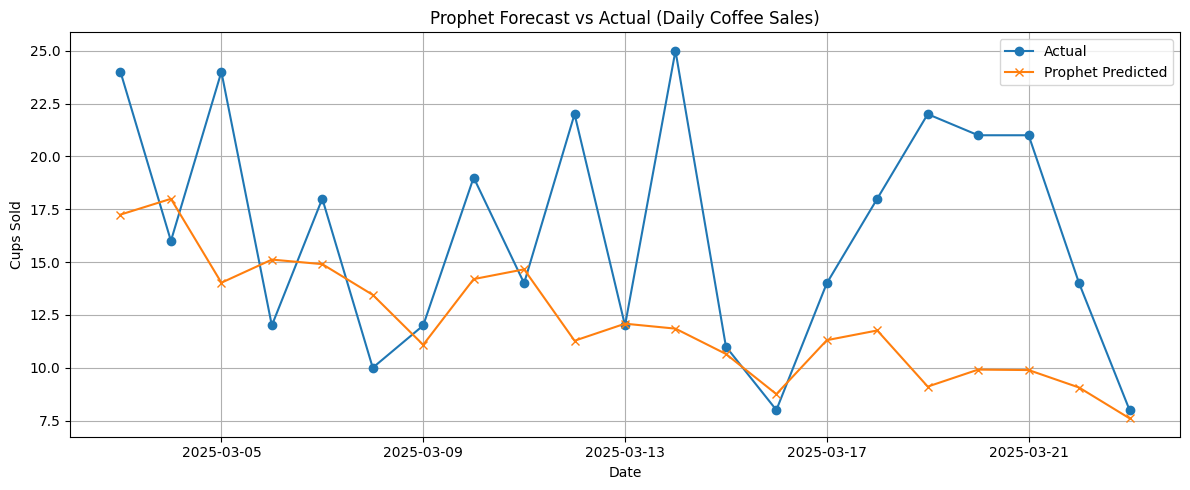

In [13]:
# Step 0: Log-transform y to stabilize variance
df_general_o['y'] = np.log1p(df_general_o['y'])

# Step 1: Split train/test (last 21 days)
train_df = df_general_o[:-21].copy()
test_df = df_general_o[-21:].copy()

# Step 2: Define parameter grid
changepoint_range = [0.01, 0.05, 0.1, 0.3]
seasonality_range = [1.0, 5.0, 10.0, 15.0]

results = []

# Step 3: Grid search over parameters
for cp in changepoint_range:
    for sp in seasonality_range:
        print(f"Training: changepoint_prior_scale={cp}, seasonality_prior_scale={sp}")
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=cp,
            seasonality_prior_scale=sp
        )
        m.add_country_holidays(country_name='MY')

        m.fit(train_df)

        # Run cross-validation
        df_cv = cross_validation(m, initial='345 days', period='7 days', horizon='21 days', parallel="processes")
        df_p = performance_metrics(df_cv)

        avg_mape = df_p['mape'].mean()
        avg_mae = df_p['mae'].mean()
        avg_rmse = df_p['rmse'].mean()

        results.append({
            'changepoint_prior_scale': cp,
            'seasonality_prior_scale': sp,
            'mae': avg_mae,
            'rmse': avg_rmse,
            'mape': avg_mape
        })

# Step 4: Display best params
results_df = pd.DataFrame(results)
best_params = results_df[results_df['mape'].notnull()].sort_values(by='mape').iloc[0]
print("\nBest Parameters:")
print(best_params)

# Step 5: Retrain with best parameters on full training data
best_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)
best_model.add_country_holidays(country_name='MY')
best_model.fit(train_df)

# Step 6: Forecast next 21 days
future = best_model.make_future_dataframe(periods=21, freq='D')
forecast = best_model.predict(future)

# Step 7: Inverse transform and evaluate
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
y_true = np.expm1(test_df['y'].values)
y_pred = forecast['yhat'].values[-21:]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"\nFinal Test MAE (best model): {mae:.2f}")
print(f"Final Test RMSE (best model): {rmse:.2f}")
print(f"Final Test MAPE (best model): {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Cups Sold")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

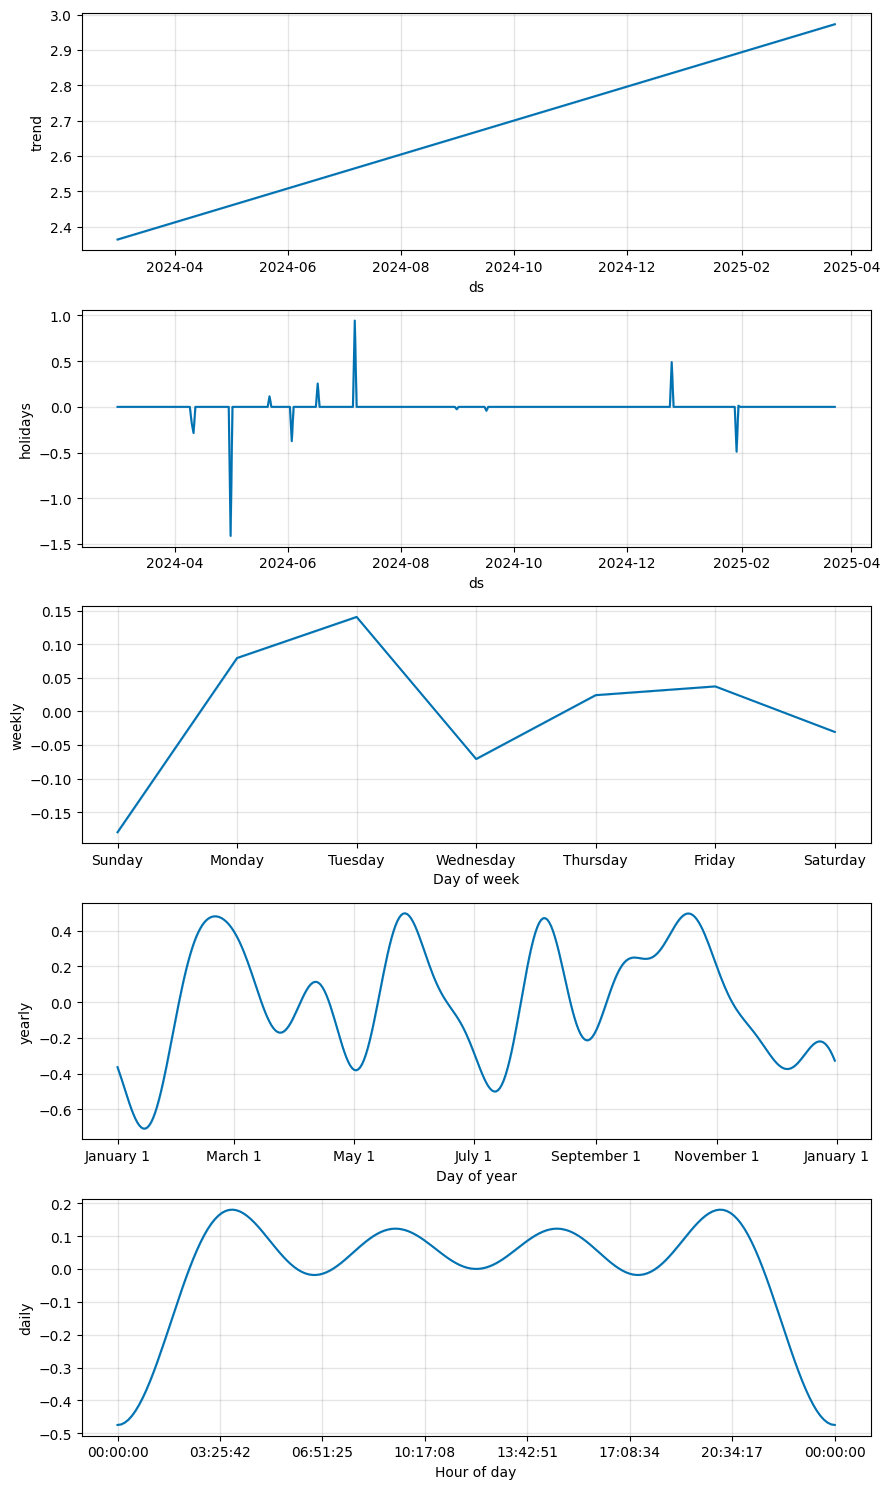

In [14]:
fig = best_model.plot_components(forecast)
plt.tight_layout()
plt.show()

## Specific

In [15]:
def model_o (coffee_name):
    # Step 1: Prepare data
    df_dailyc = coffee_dfs_o[coffee_name].rename(columns={'datetime': 'ds', coffee_name: 'y'})

    df_dailyc['y'] = np.log1p(df_dailyc['y'])

    # Step 2: Split into train and test sets
    train_df = df_dailyc[:-21]
    test_df = df_dailyc[-21:]

    # Step 3: Train the model on the training set
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=15
    )
    model.add_country_holidays(country_name='MY') 
    model.fit(train_df)

    # Step 4: Create future DataFrame for next 21 days
    future = model.make_future_dataframe(periods=21, freq='D')

    # Step 5: Predict
    forecast = model.predict(future)

    # Step 6: Inverse transform and clip
    forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
    y_true = np.expm1(test_df['y'].values)
    y_pred = forecast['yhat'].values[-21:]

    # Step 7: Evaluation on test set only
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"Daily Prophet MAE: {mae:.2f}")
    print(f"Daily Prophet RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Step 8: Plot forecast vs actual
    plt.figure(figsize=(12, 5))
    plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
    plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
    plt.title("Prophet Forecast vs Actual (Daily " + coffee_name + " Sales)")
    plt.xlabel("Date")
    plt.ylabel("Cups Sold")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()  
    
    fig = model.plot_components(forecast)
    plt.tight_layout()
    plt.show()
    

### Americano

17:49:48 - cmdstanpy - INFO - Chain [1] start processing
17:49:48 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 2.33
Daily Prophet RMSE: 3.02
MAPE: 51.69%


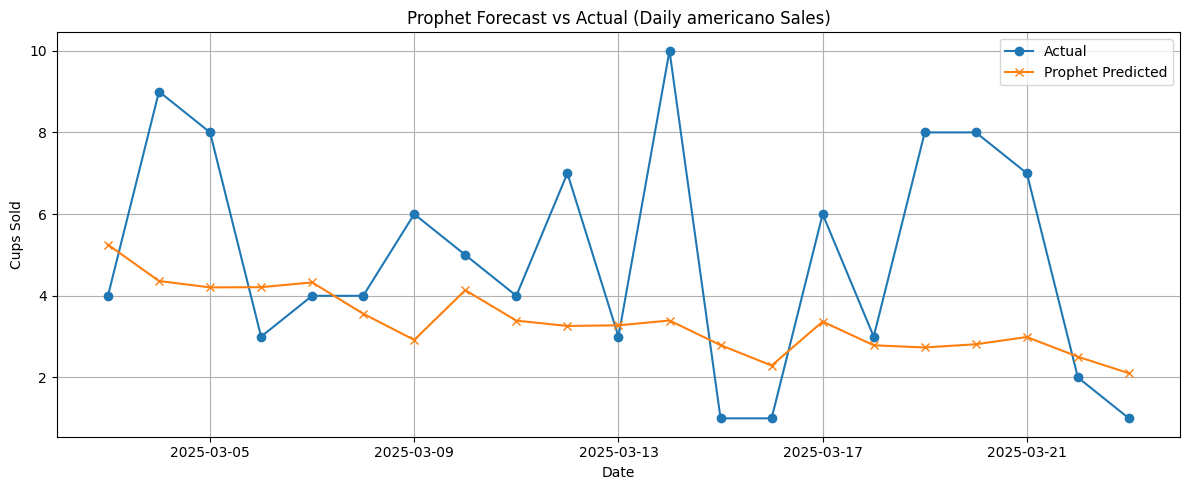

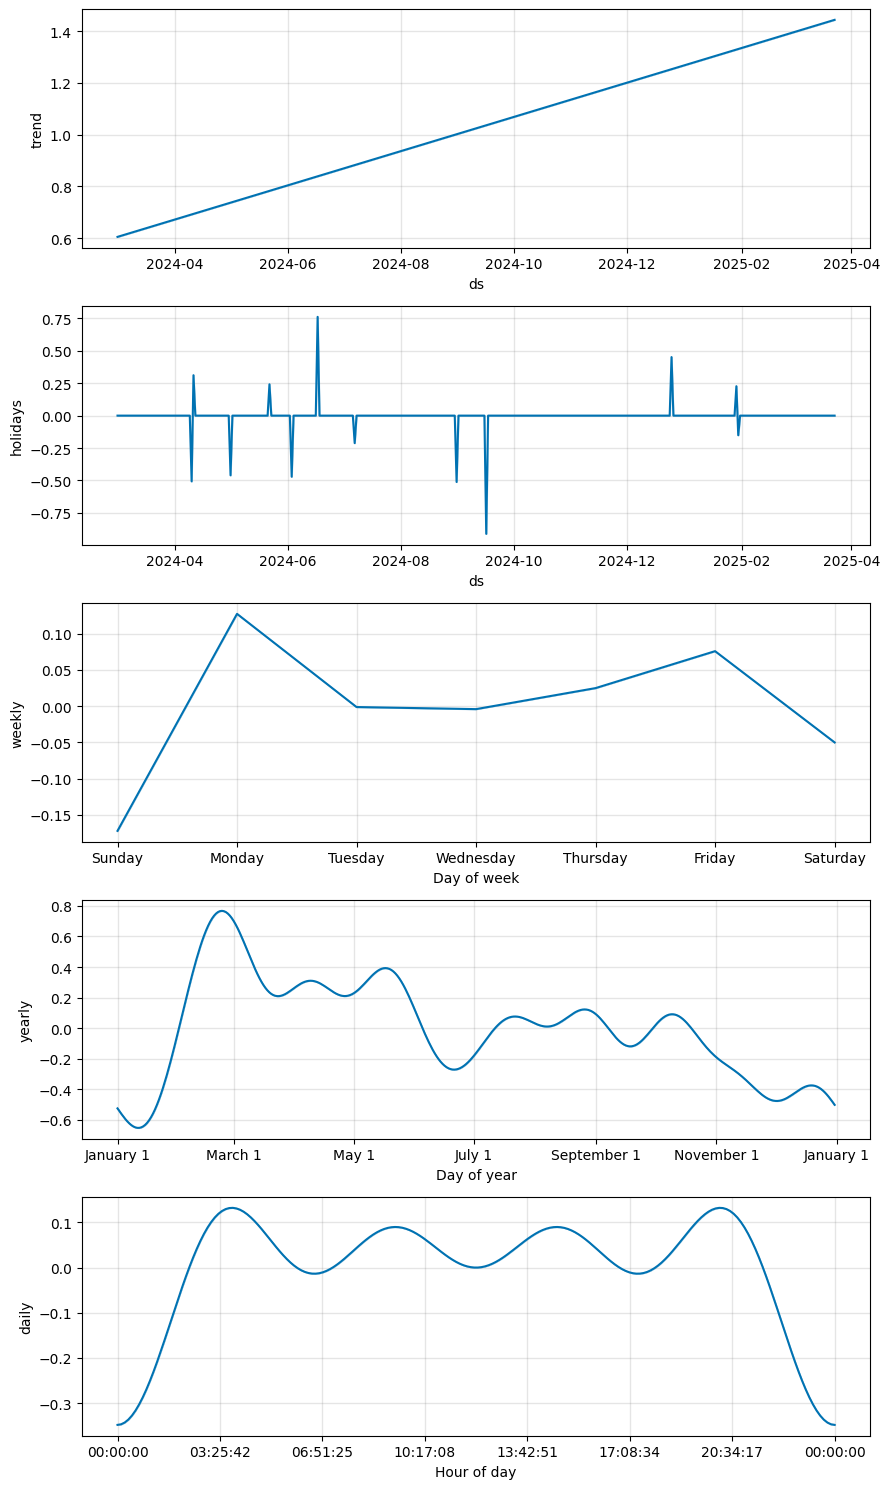

In [16]:
model_o('americano')  

### Americano with Milk

17:49:51 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 1.53
Daily Prophet RMSE: 2.05
MAPE: 47.94%


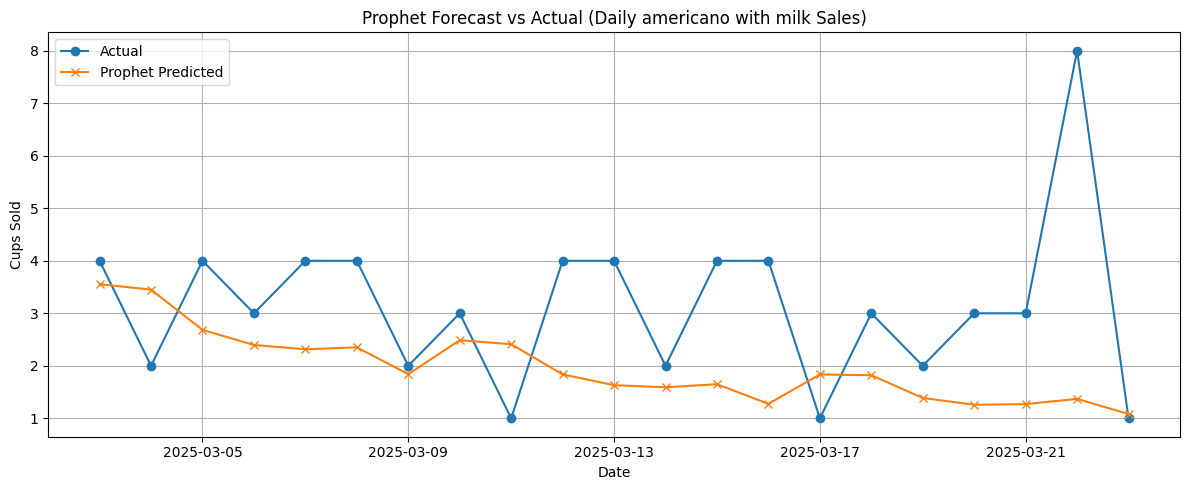

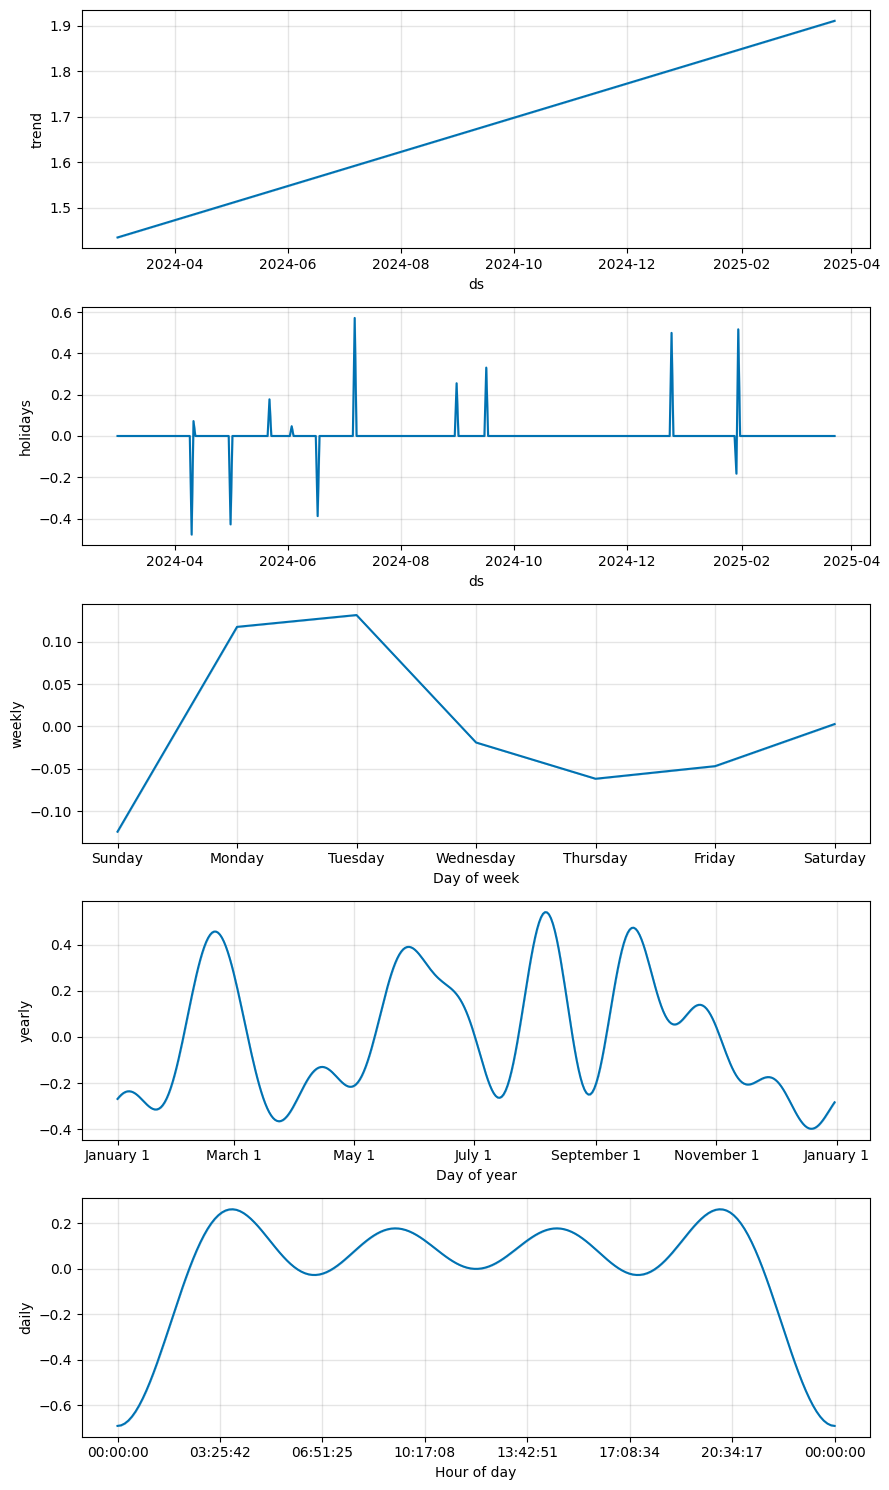

In [17]:
model_o('americano with milk')  

### Cappuccino

17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 1.32
Daily Prophet RMSE: 1.61
MAPE: 77.00%


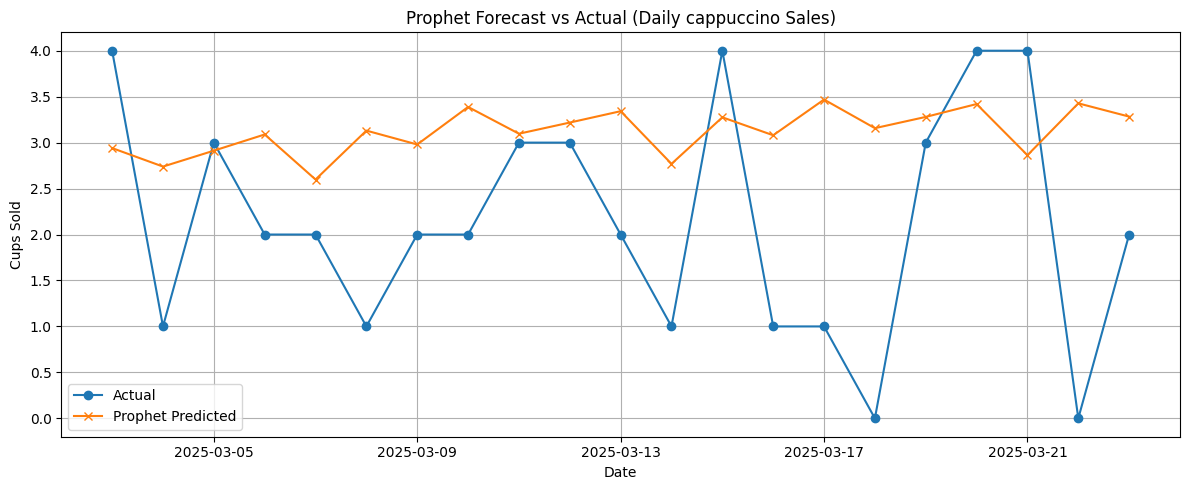

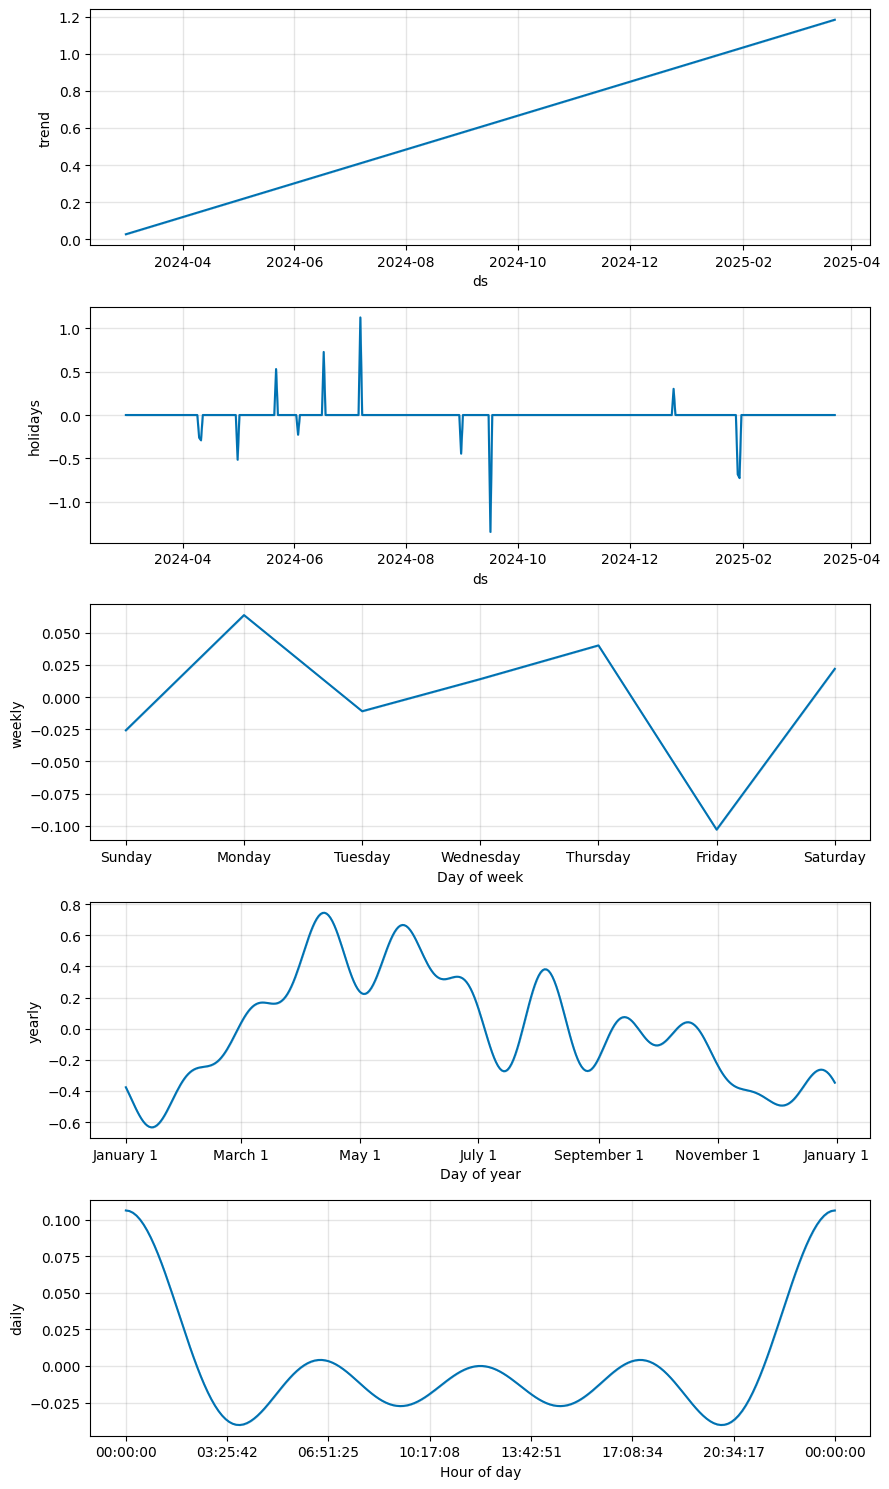

In [18]:
model_o('cappuccino')  

### Cocoa

17:49:58 - cmdstanpy - INFO - Chain [1] start processing
17:49:58 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 0.79
Daily Prophet RMSE: 0.99
MAPE: 32.78%


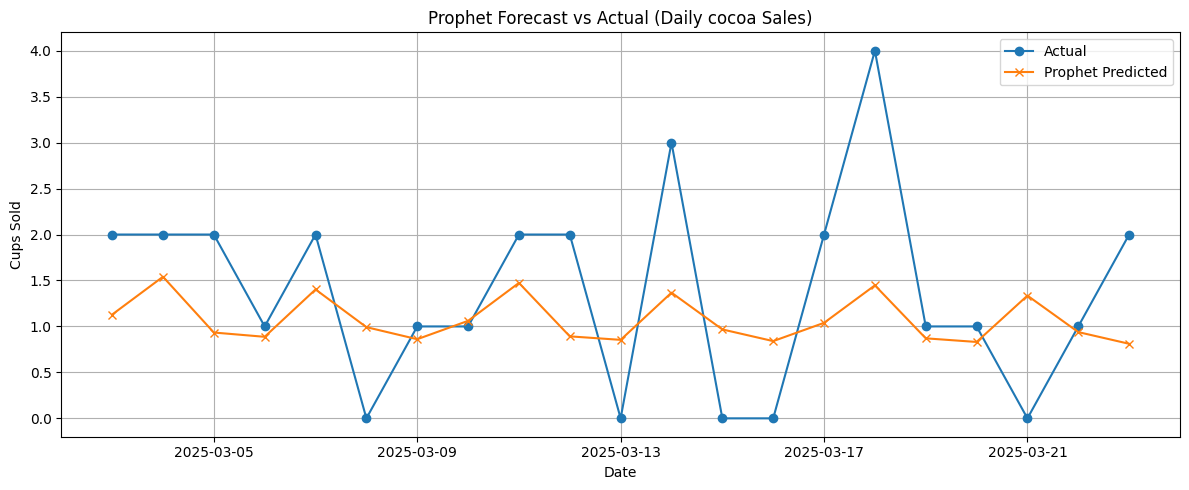

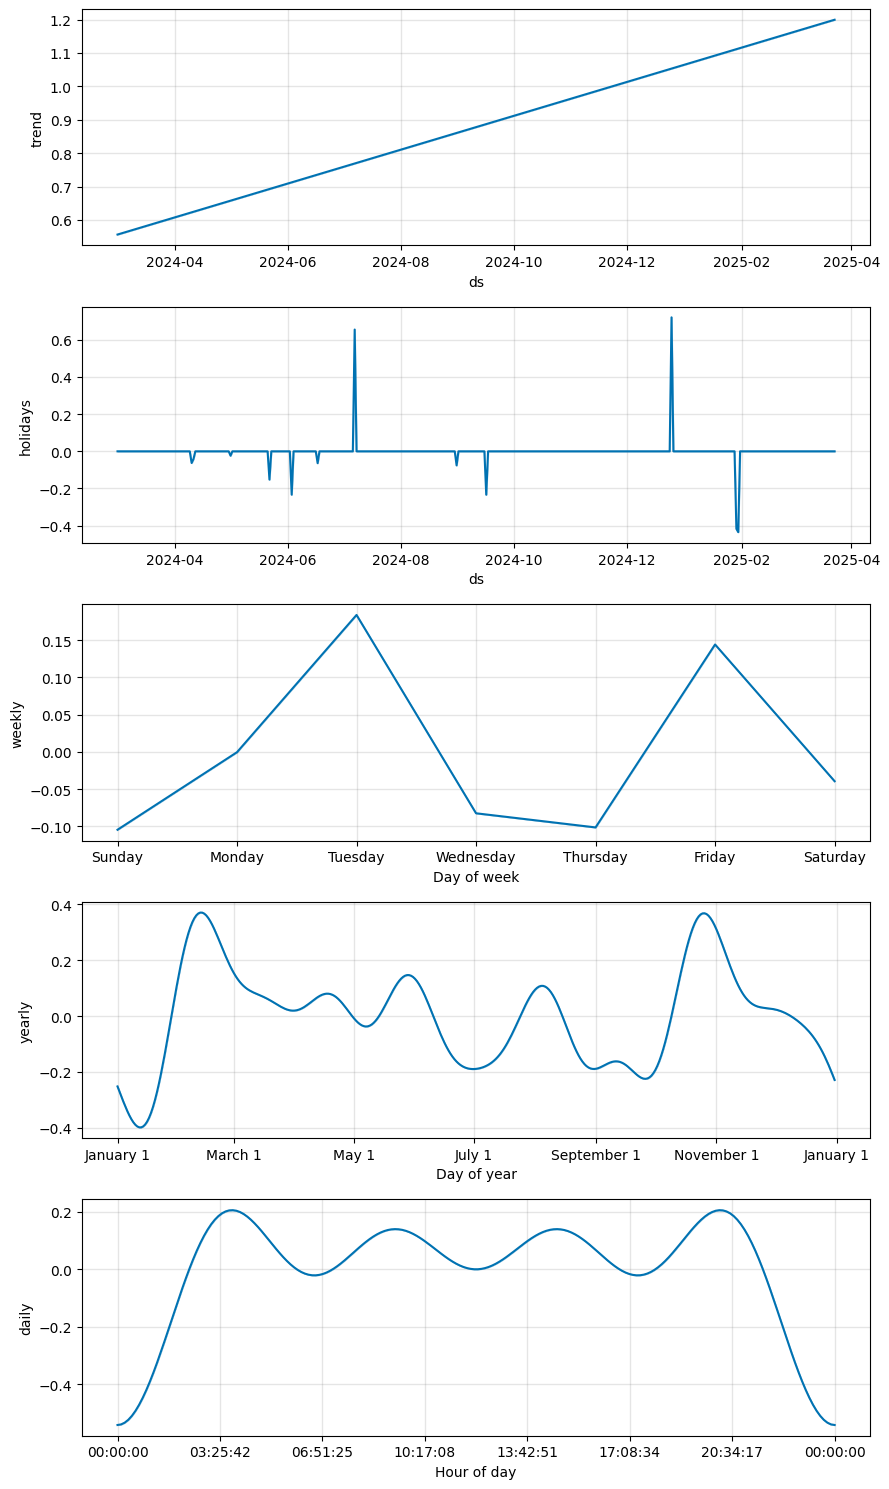

In [19]:
model_o('cocoa')  

### Cortado

17:50:01 - cmdstanpy - INFO - Chain [1] start processing
17:50:01 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 0.42
Daily Prophet RMSE: 0.46
MAPE: 49.91%


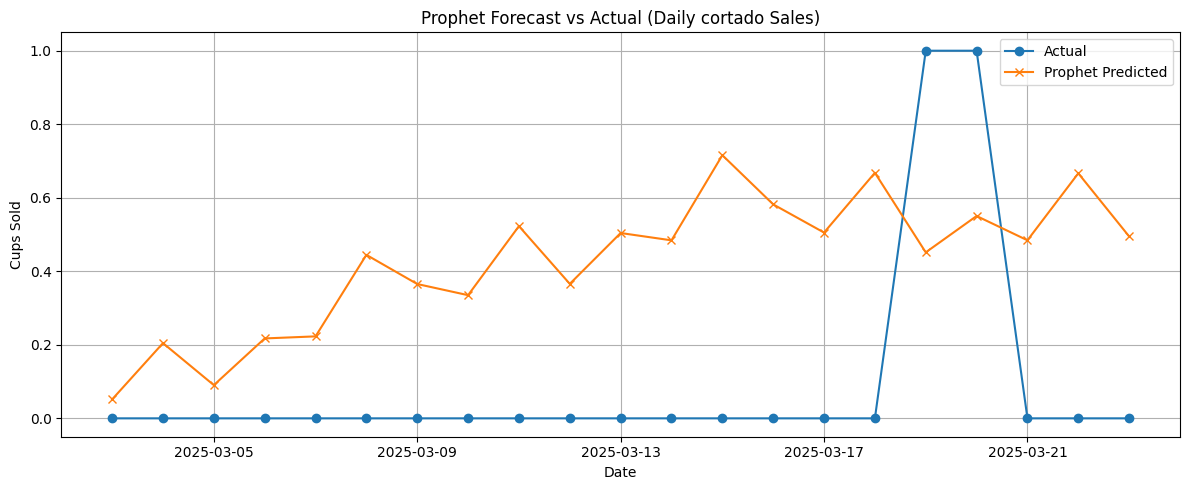

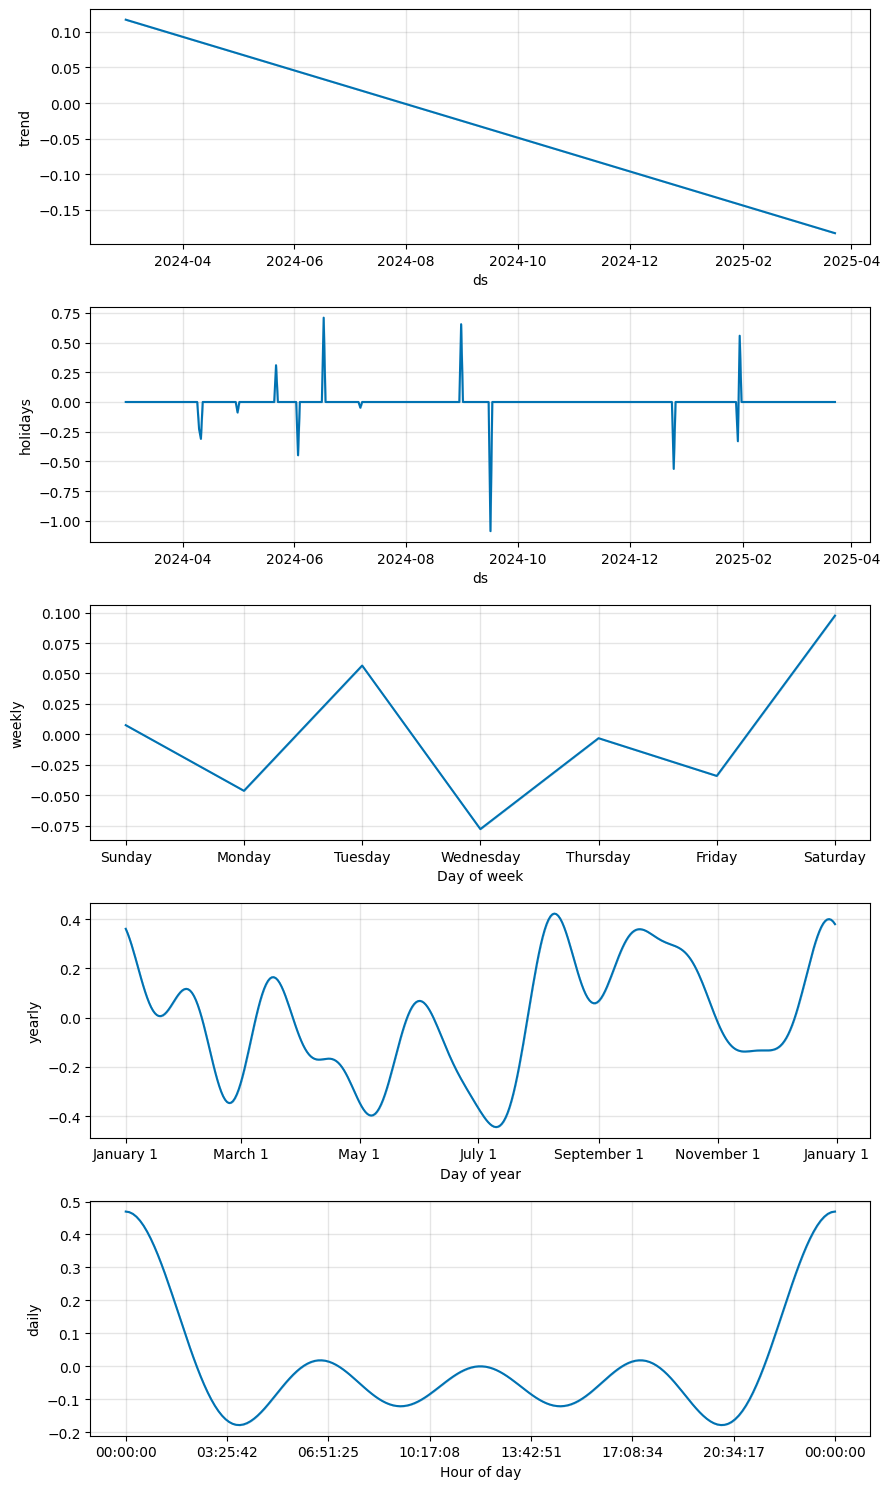

In [20]:
model_o('cortado')  

### Espresso

17:50:04 - cmdstanpy - INFO - Chain [1] start processing
17:50:05 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 0.65
Daily Prophet RMSE: 0.81
MAPE: 74.17%


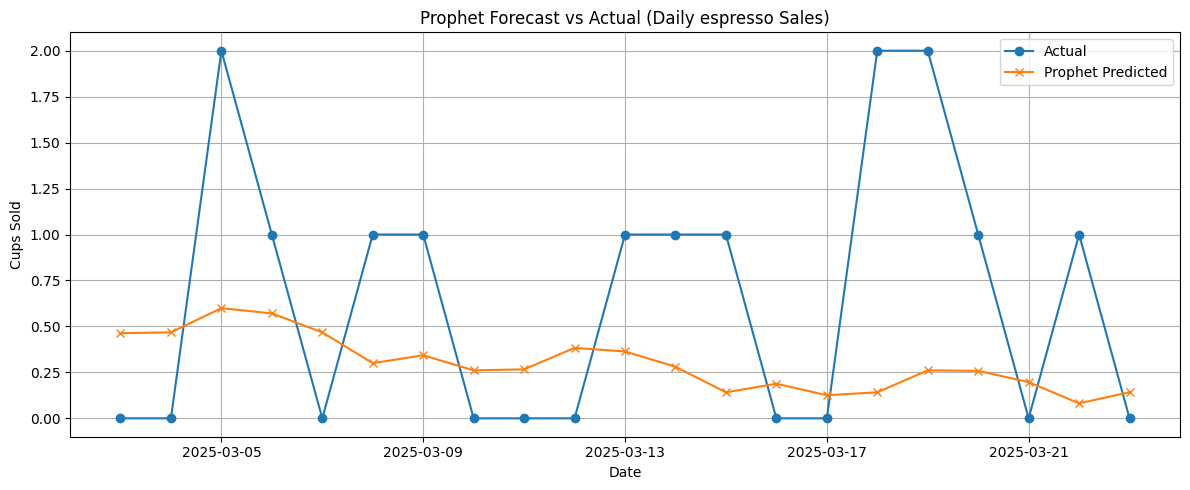

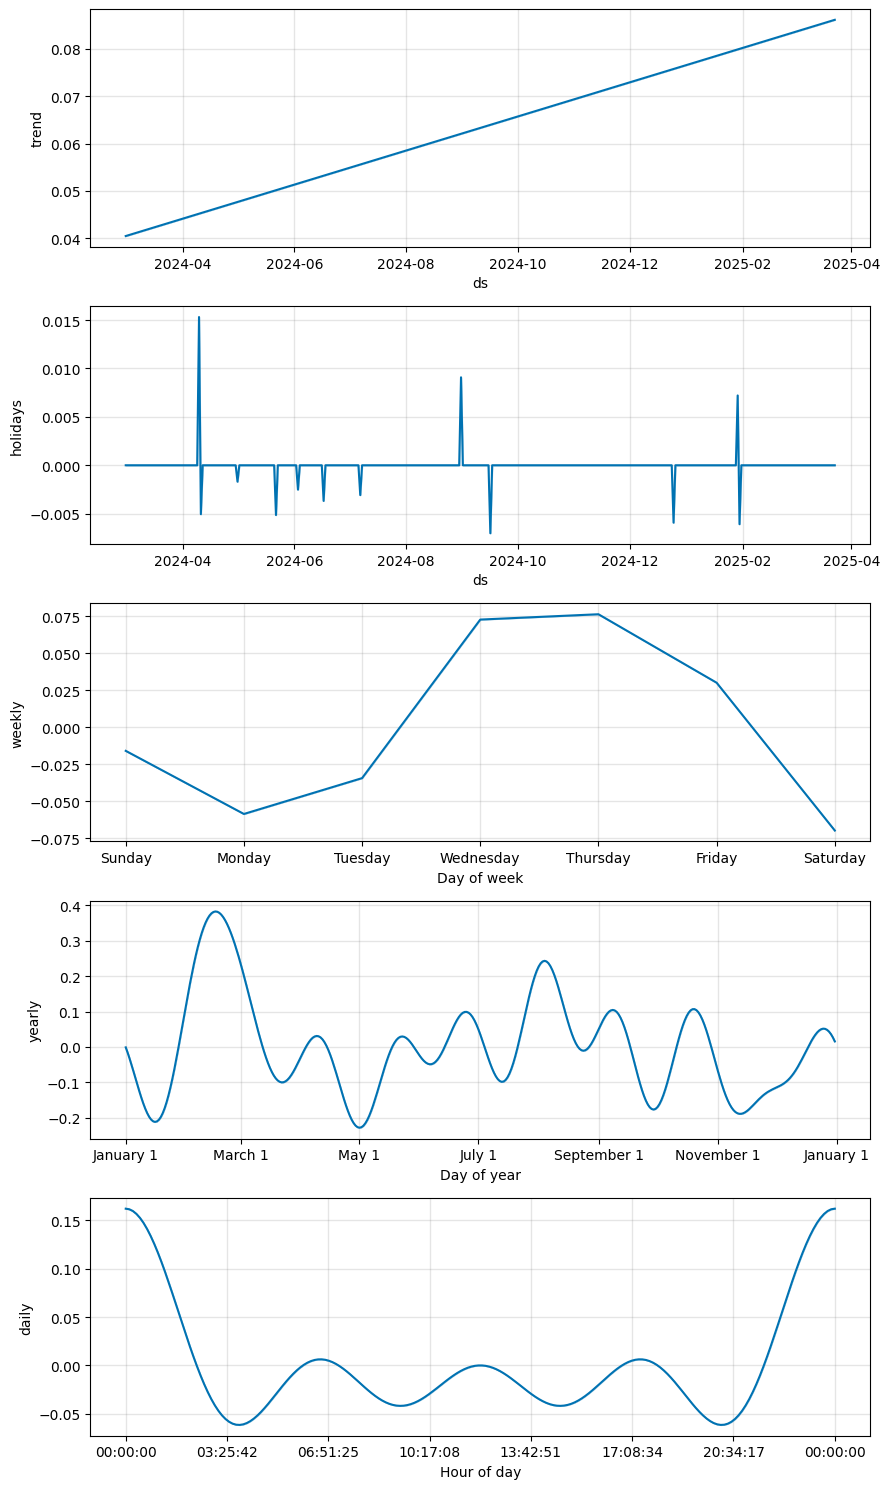

In [21]:
model_o('espresso') 

### Hot Chocolate

17:50:08 - cmdstanpy - INFO - Chain [1] start processing
17:50:08 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 1.08
Daily Prophet RMSE: 1.62
MAPE: 96.49%


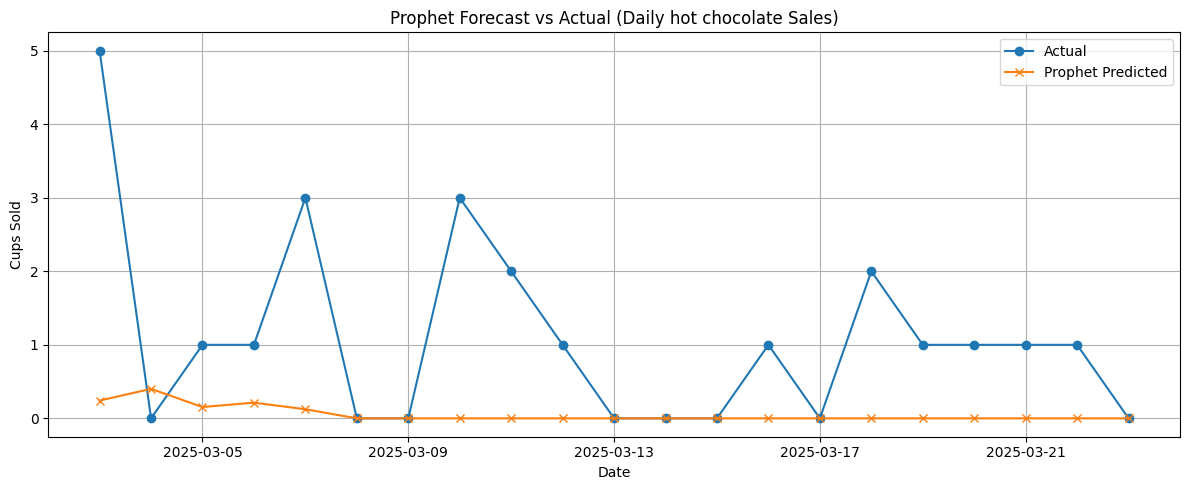

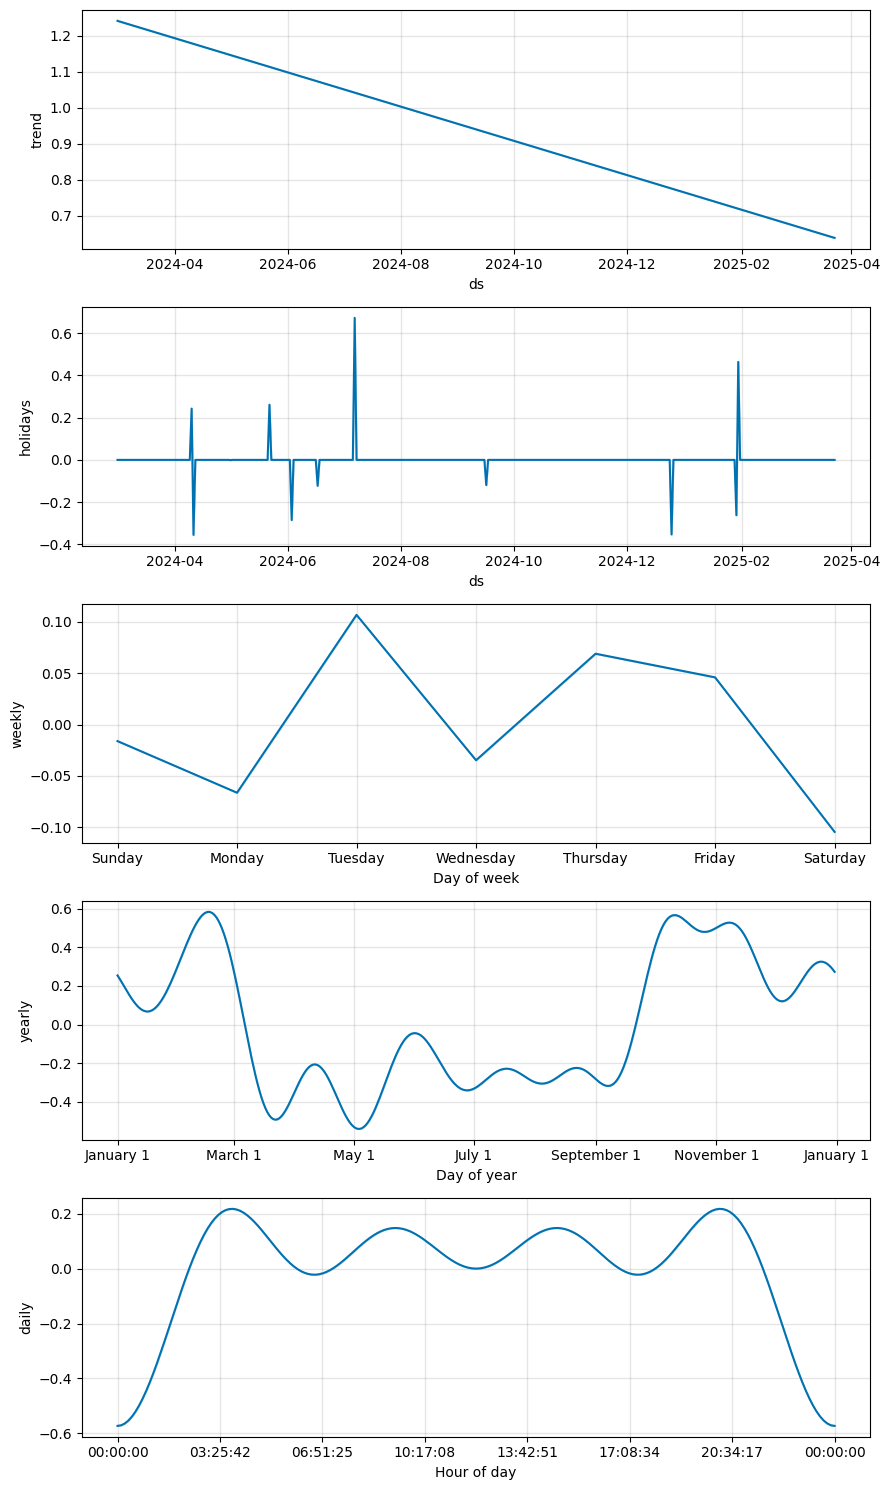

In [22]:
model_o('hot chocolate')

### Latte

17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 1.86
Daily Prophet RMSE: 2.52
MAPE: 47.21%


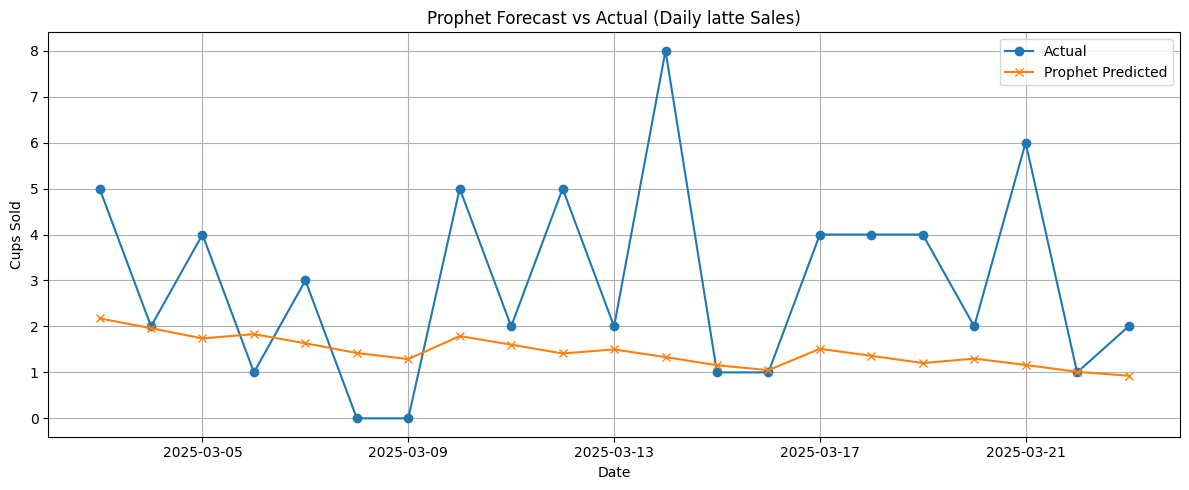

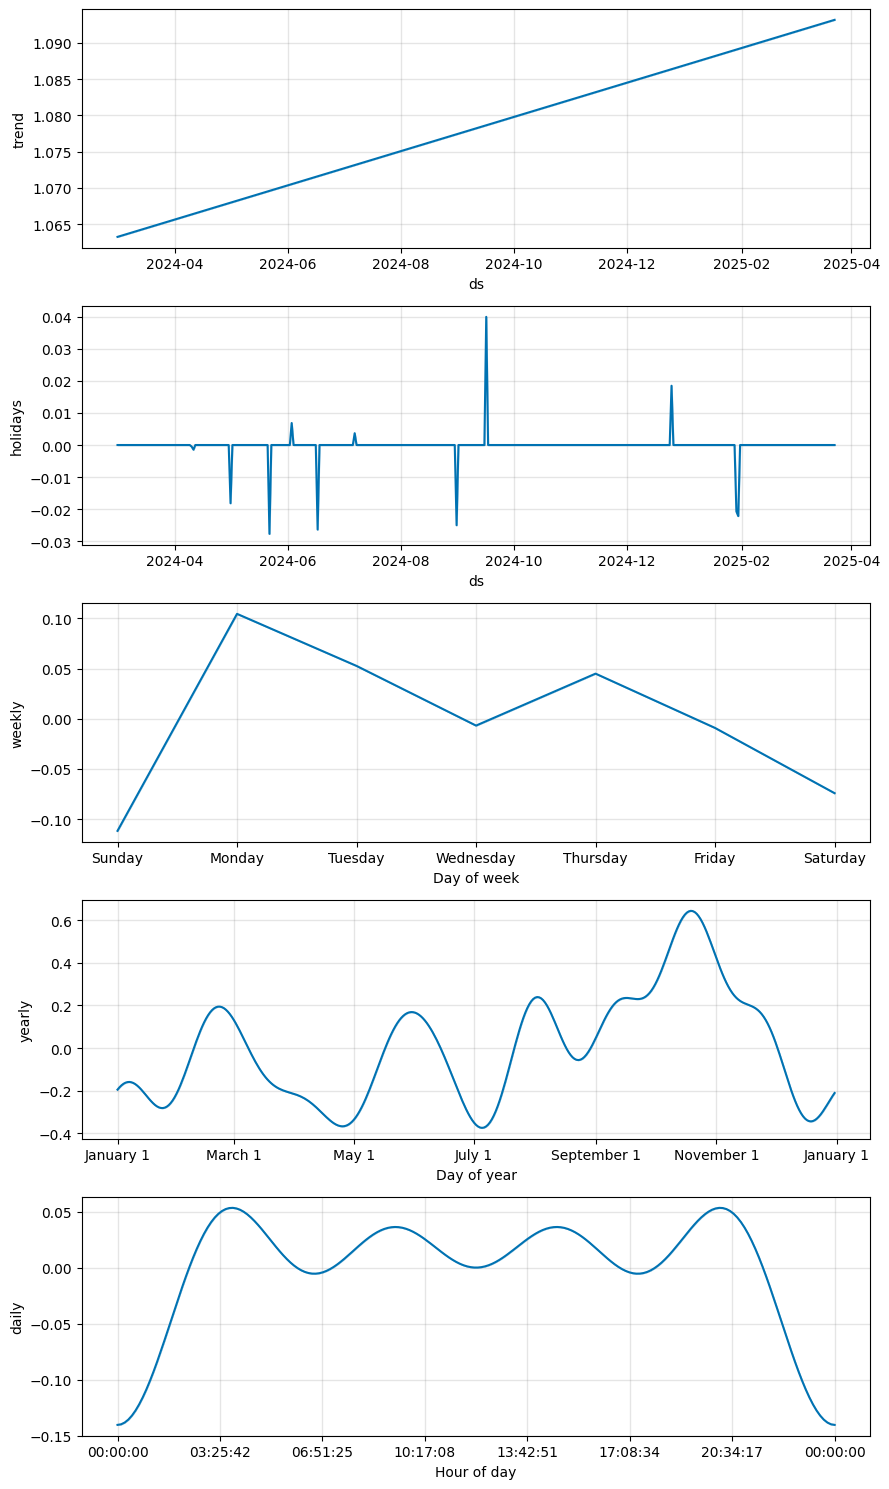

In [23]:
model_o('latte')

# By Sales

In [24]:
df_s = pd.read_csv('Dataset/top9_coffee_revenue_by_column.csv')

In [25]:
df_s['datetime'] = pd.to_datetime(df_s['datetime'])

In [26]:
df_s = df_s.resample('D', on='datetime').sum().reset_index()

In [27]:
df_s.head()

datetime  americano  americano with milk  cappuccino  cocoa  cortado  \
0 2024-03-01       28.9                135.2         0.0   38.7      0.0   
1 2024-03-02       86.7                101.4         0.0    0.0      0.0   
2 2024-03-03       28.9                 67.6         0.0   38.7     57.8   
3 2024-03-04        0.0                 33.8         0.0    0.0      0.0   
4 2024-03-05        0.0                  0.0         0.0   38.7     28.9   

   espresso  hot chocolate  irish whiskey  latte  
0       0.0          116.1              0   77.4  
1       0.0            0.0              0   40.0  
2       0.0           77.4              0   78.7  
3      24.0            0.0              0   77.4  
4       0.0          154.8              0  116.1

In [28]:
# List of coffee types (excluding datetime)
coffee_types_s = ['americano', 'americano with milk', 'cappuccino', 'cocoa', 'cortado',
                'espresso', 'hot chocolate', 'irish whiskey', 'latte']

# Dictionary to store the individual DataFrames
coffee_df_s = {}

# Create one DataFrame per coffee type
for coffee in coffee_types_s:
    coffee_df_s[coffee] = df_s[['datetime', coffee]].copy()

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## General

In [30]:
df_general_s = df_s.copy()
df_general_s['y'] = df_general_s[coffee_types_s].sum(axis=1)

In [31]:
df_general_s = df_general_s.rename(columns={'datetime': 'ds', 'y': 'y'})
df_general_s = df_general_s[['ds', 'y']]

17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 187.48
Daily Prophet RMSE: 231.56
Daily Prophet MAPE: 32.46%


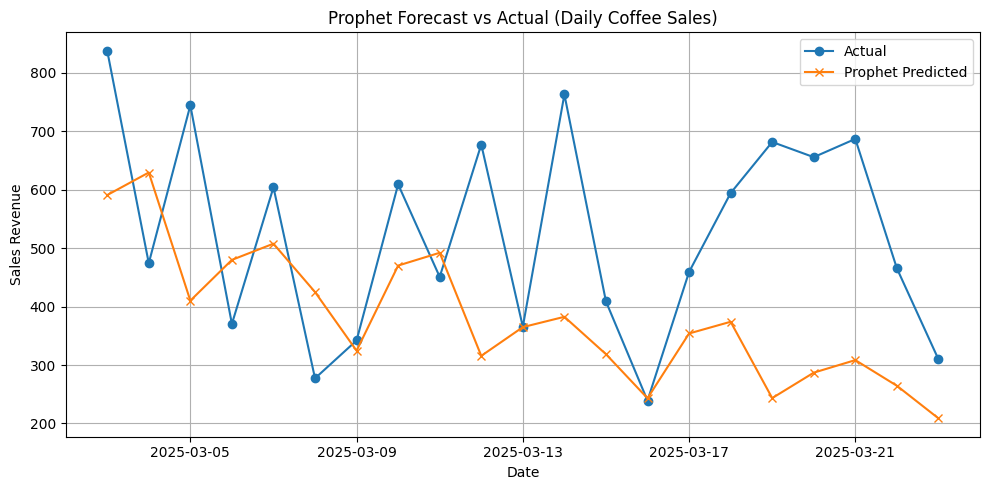

In [32]:
df_general_s['y'] = np.log1p(df_general_s['y'])

# Step 1: Split into train and test sets
train_df = df_general_s[:-21]
test_df = df_general_s[-21:]

# Step 2: Train the model on the training set
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True 
)
model.add_country_holidays(country_name='MY') 
model.fit(train_df)

# Step 4: Create future DataFrame for next 21 days
future = model.make_future_dataframe(periods=21, freq='D')

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Inverse transform and clip
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)

# Step 7: Evaluation on test set only
forecast_test = forecast[-21:].copy()
y_true = np.expm1(test_df['y'].values)
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Daily Prophet MAE: {mae:.2f}")
print(f"Daily Prophet RMSE: {rmse:.2f}")
print(f"Daily Prophet MAPE: {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(10, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Sales Revenue")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  

### Tuning

In [33]:
df_general_s = df_s.copy()
df_general_s['y'] = df_general_s[coffee_types_s].sum(axis=1)

In [34]:
df_general_s = df_general_s.rename(columns={'datetime': 'ds', 'y': 'y'})
df_general_s = df_general_s[['ds', 'y']]

Training: changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=5.0


17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=15.0


17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=1.0


17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=5.0


17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=10.0


17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=15.0


17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=5.0


17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=15.0


17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=1.0


17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=5.0


17:51:27 - cmdstanpy - INFO - Chain [1] start processing
17:51:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=10.0


17:51:32 - cmdstanpy - INFO - Chain [1] start processing
17:51:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=15.0


17:51:38 - cmdstanpy - INFO - Chain [1] start processing
17:51:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Best Parameters:
changepoint_prior_scale     0.050000
seasonality_prior_scale    10.000000
mae                         0.330306
rmse                        0.377178
mape                        0.055844
Name: 6, dtype: float64


17:51:43 - cmdstanpy - INFO - Chain [1] start processing
17:51:44 - cmdstanpy - INFO - Chain [1] done processing



Final Test MAE (best model): 187.48
Final Test RMSE (best model): 231.56
Final Test MAPE (best model): 32.46%


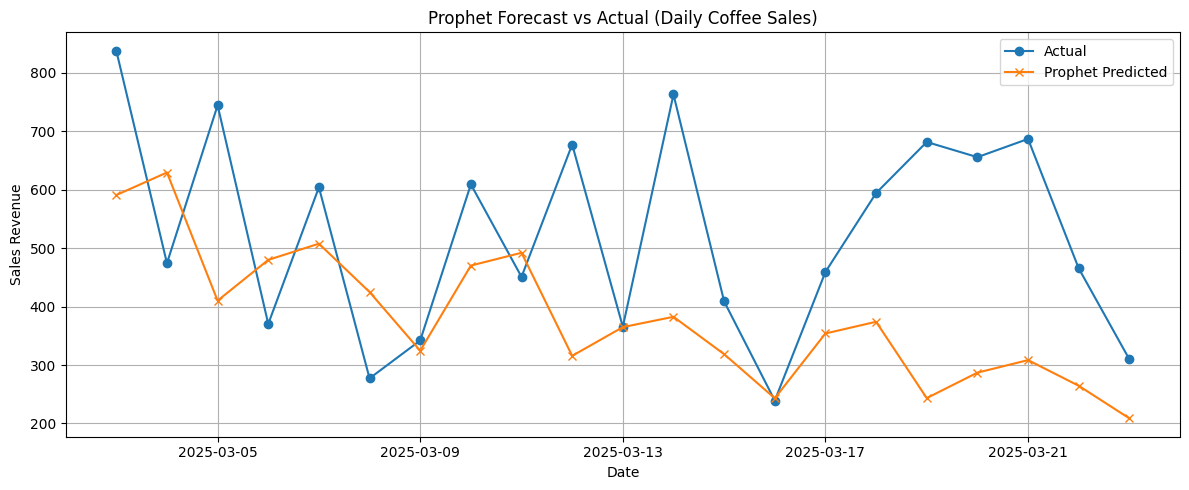

In [35]:
# Step 0: Log-transform y to stabilize variance
df_general_s['y'] = np.log1p(df_general_s['y'])

# Step 1: Split train/test (last 21 days)
train_df = df_general_s[:-21].copy()
test_df = df_general_s[-21:].copy()

# Step 2: Define parameter grid
changepoint_range = [0.01, 0.05, 0.1, 0.3]
seasonality_range = [1.0, 5.0, 10.0, 15.0]

results = []

# Step 3: Grid search over parameters
for cp in changepoint_range:
    for sp in seasonality_range:
        print(f"Training: changepoint_prior_scale={cp}, seasonality_prior_scale={sp}")
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=cp,
            seasonality_prior_scale=sp
        )
        m.add_country_holidays(country_name='MY')

        m.fit(train_df)

        # Run cross-validation
        df_cv = cross_validation(m, initial='345 days', period='7 days', horizon='21 days', parallel="processes")
        df_p = performance_metrics(df_cv)

        avg_mape = df_p['mape'].mean()
        avg_mae = df_p['mae'].mean()
        avg_rmse = df_p['rmse'].mean()

        results.append({
            'changepoint_prior_scale': cp,
            'seasonality_prior_scale': sp,
            'mae': avg_mae,
            'rmse': avg_rmse,
            'mape': avg_mape
        })

# Step 4: Display best params
results_df = pd.DataFrame(results)
best_params = results_df[results_df['mape'].notnull()].sort_values(by='mape').iloc[0]
print("\nBest Parameters:")
print(best_params)

# Step 5: Retrain with best parameters on full training data
best_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)
best_model.add_country_holidays(country_name='MY')
best_model.fit(train_df)

# Step 6: Forecast next 21 days
future = best_model.make_future_dataframe(periods=21, freq='D')
forecast = best_model.predict(future)

# Step 7: Inverse transform and evaluate
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
y_true = np.expm1(test_df['y'].values)
y_pred = forecast['yhat'].values[-21:]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"\nFinal Test MAE (best model): {mae:.2f}")
print(f"Final Test RMSE (best model): {rmse:.2f}")
print(f"Final Test MAPE (best model): {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Sales Revenue")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

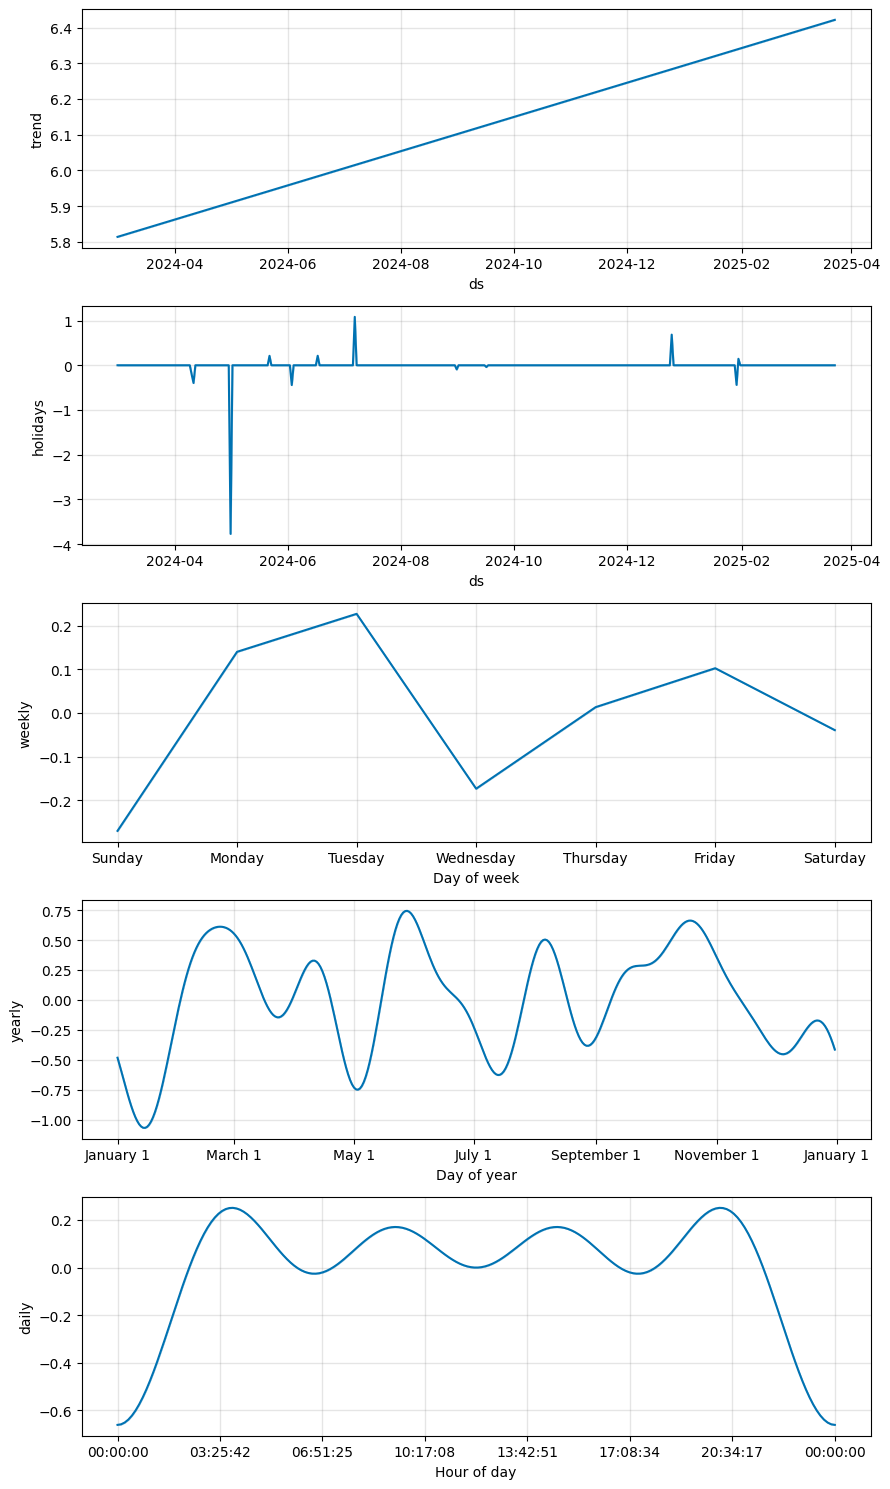

In [36]:
fig = best_model.plot_components(forecast)
plt.tight_layout()
plt.show()

## Specific

In [37]:
def model_s (coffee_name):
    # Step 1: Prepare data
    df_dailys = coffee_df_s[coffee_name].rename(columns={'datetime': 'ds', coffee_name: 'y'})

    df_dailys['y'] = np.log1p(df_dailys['y'])

    # Step 2: Split into train and test sets
    train_df = df_dailys[:-21]
    test_df = df_dailys[-21:]

    # Step 3: Train the model on the training set
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.5,
        seasonality_prior_scale=10
    )
    model.add_country_holidays(country_name='MY') 
    model.fit(train_df)

    # Step 4: Create future DataFrame for next 21 days
    future = model.make_future_dataframe(periods=21, freq='D')

    # Step 5: Predict
    forecast = model.predict(future)

    # Step 6: Inverse transform and clip
    forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
    y_true = np.expm1(test_df['y'].values)
    y_pred = forecast['yhat'].values[-21:]

    # Step 7: Evaluation on test set only
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"Daily Prophet MAE: {mae:.2f}")
    print(f"Daily Prophet RMSE: {rmse:.2f}")
    print(f"Daily Prophet MAPE: {mape:.2f}%")

    # Step 8: Plot forecast vs actual
    plt.figure(figsize=(12, 5))
    plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
    plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
    plt.title("Prophet Forecast vs Actual (Daily " + coffee_name + " Sales)")
    plt.xlabel("Date")
    plt.ylabel("Sales Revenue")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()  
    
    fig = model.plot_components(forecast)
    plt.tight_layout()
    plt.show()
    

### Americano

17:51:47 - cmdstanpy - INFO - Chain [1] start processing
17:51:47 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 90.30
Daily Prophet RMSE: 113.27
Daily Prophet MAPE: 62.30%


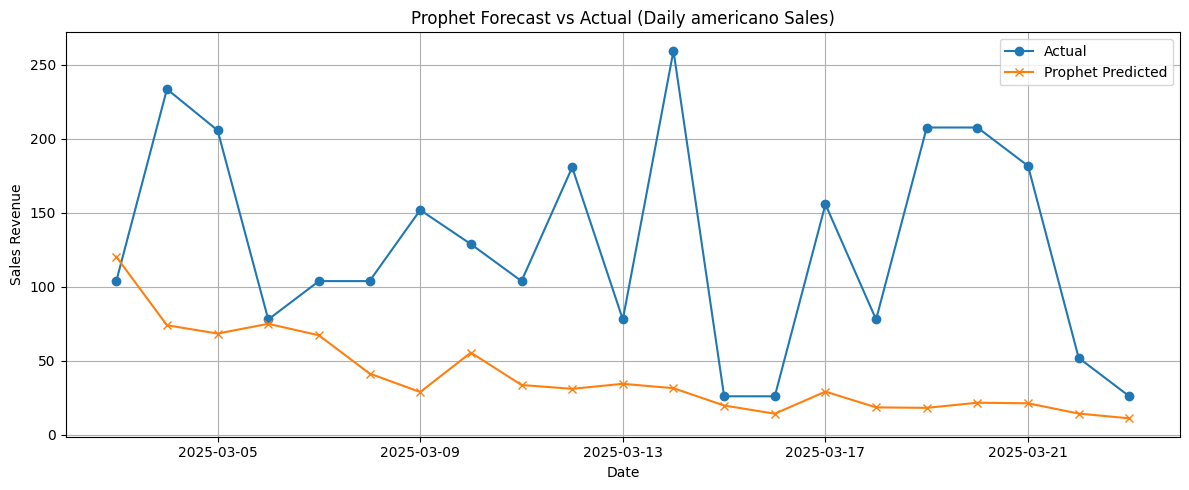

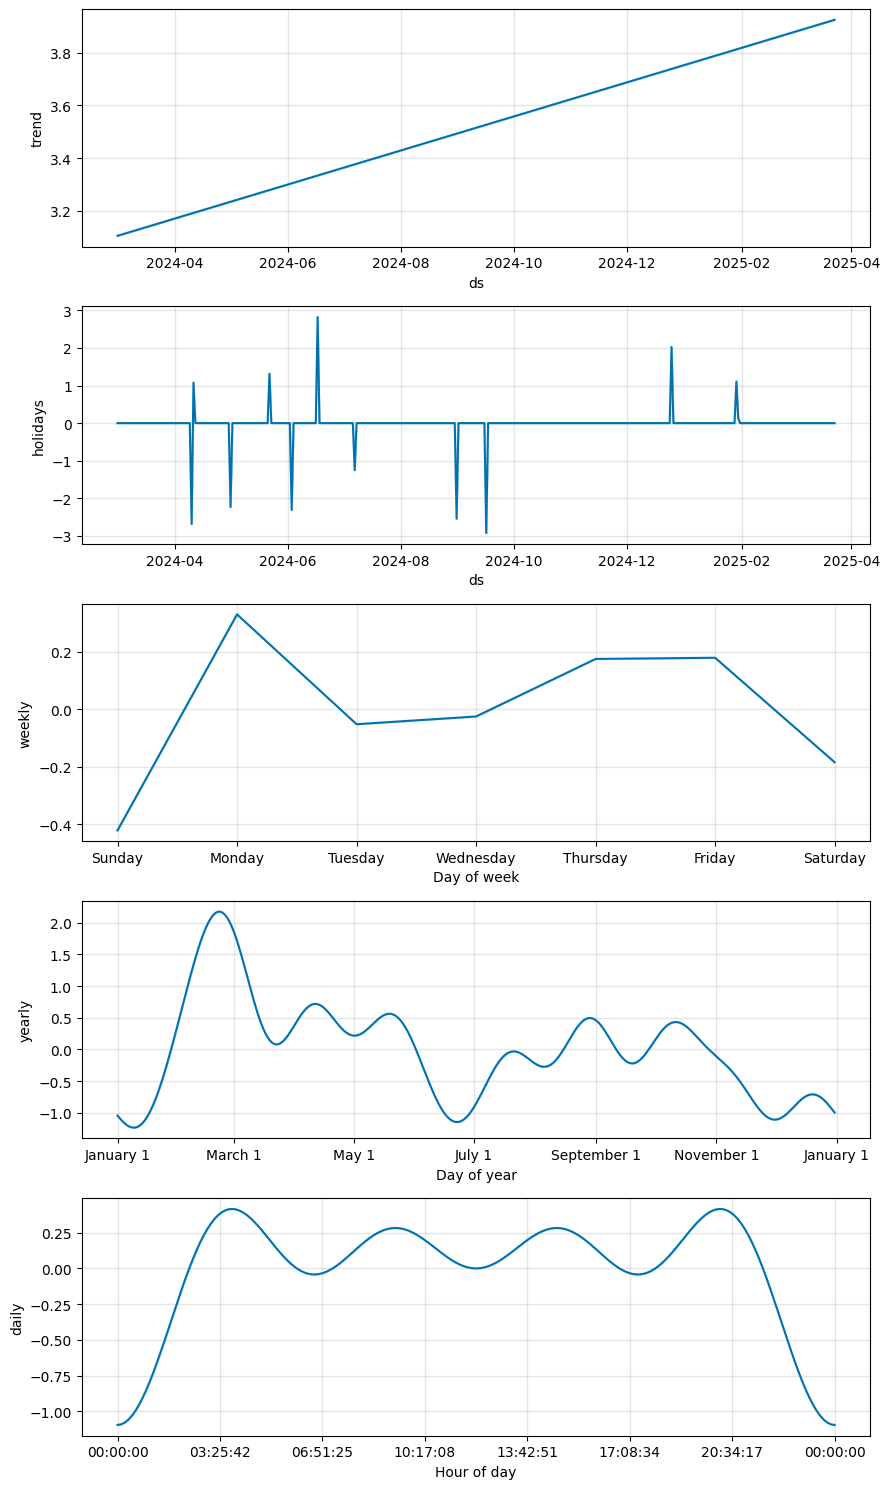

In [38]:
model_s('americano')  

### Americano with Milk

17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 71.74
Daily Prophet RMSE: 86.16
Daily Prophet MAPE: 74.05%


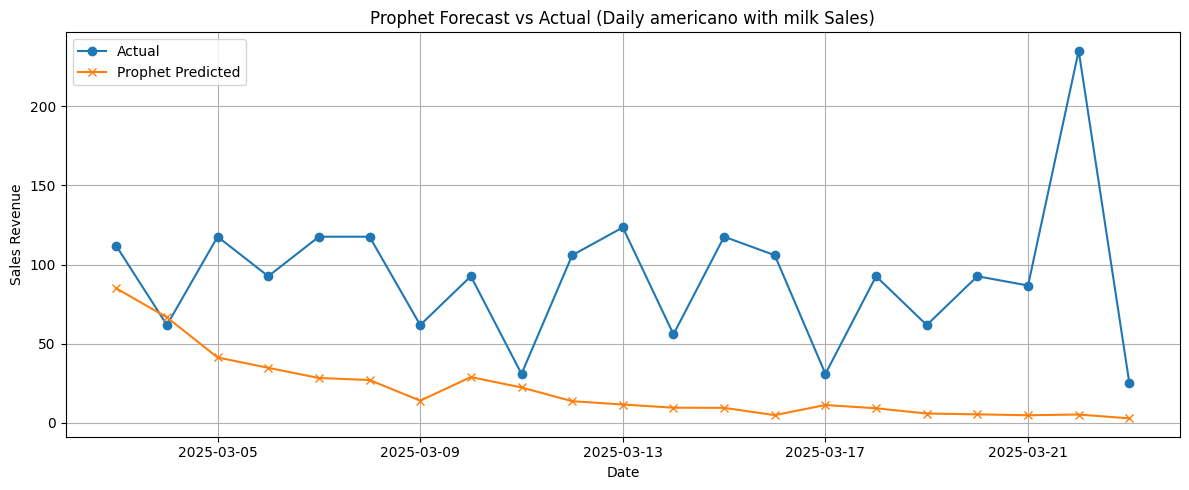

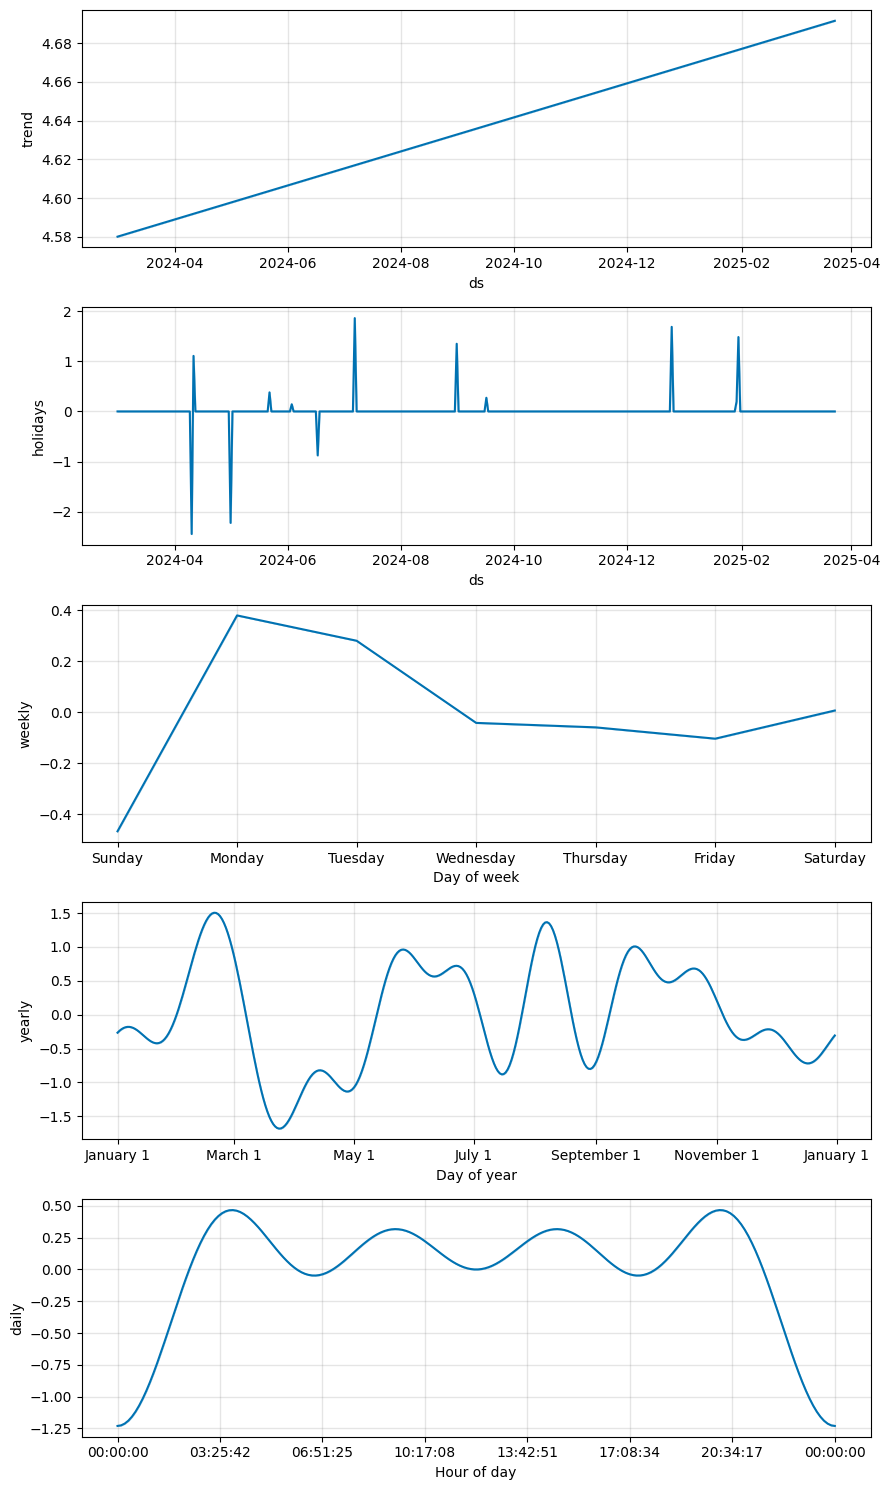

In [39]:
model_s('americano with milk')  

### Cappuccino

17:51:52 - cmdstanpy - INFO - Chain [1] start processing
17:51:53 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 158.76
Daily Prophet RMSE: 185.12
Daily Prophet MAPE: 233.60%


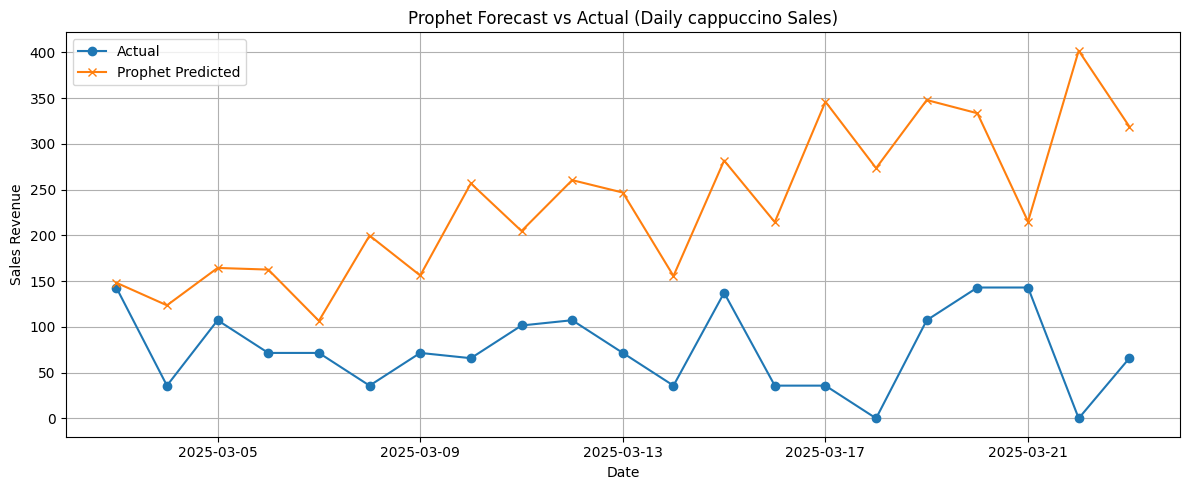

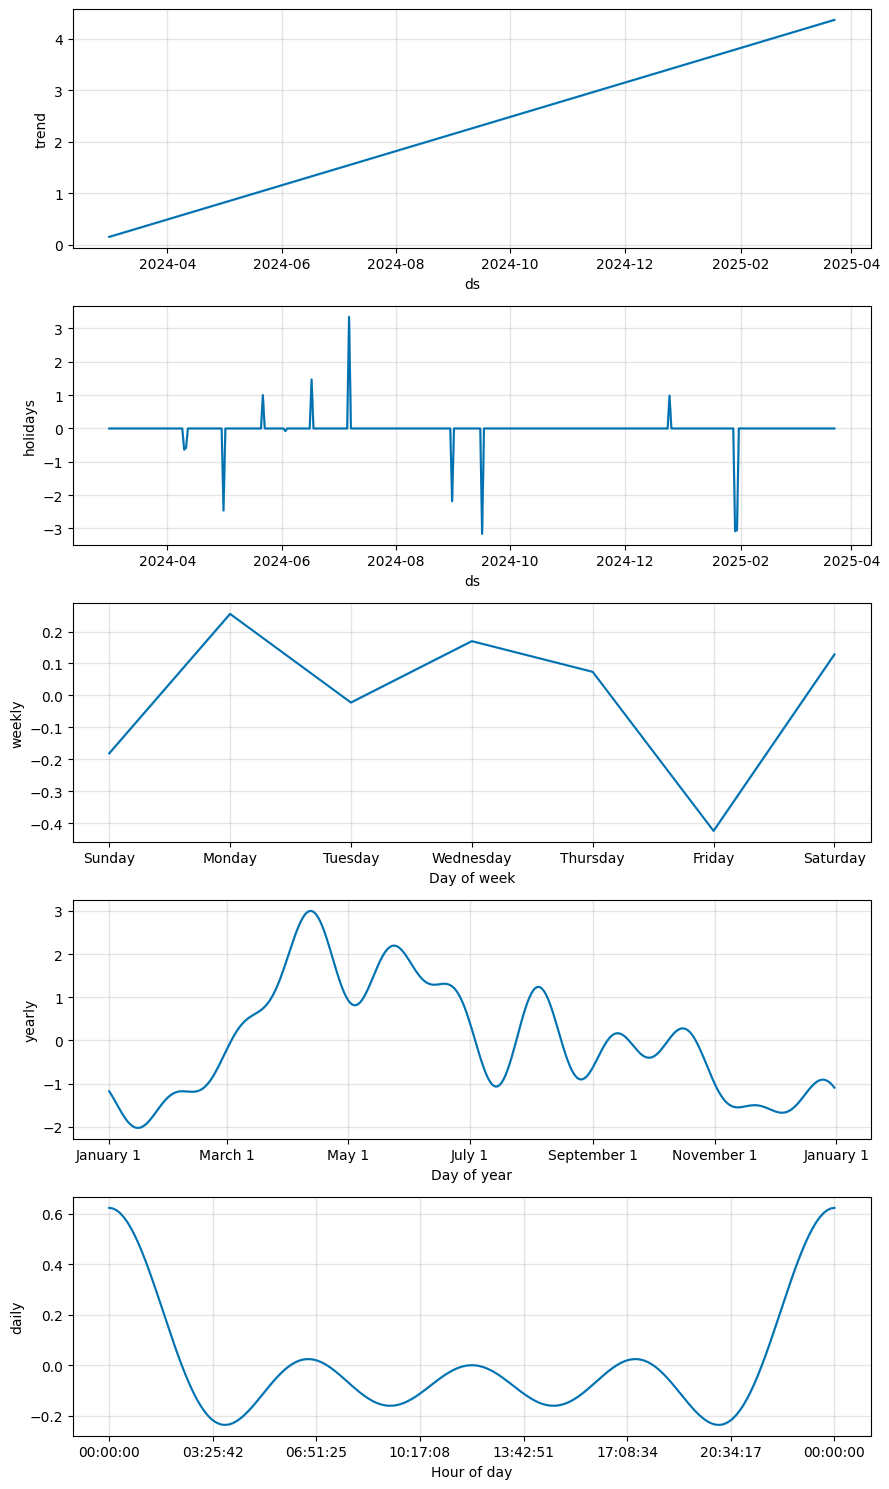

In [40]:
model_s('cappuccino')  

### Cocoa

17:51:56 - cmdstanpy - INFO - Chain [1] start processing
17:51:56 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 43.39
Daily Prophet RMSE: 53.39
Daily Prophet MAPE: 84.06%


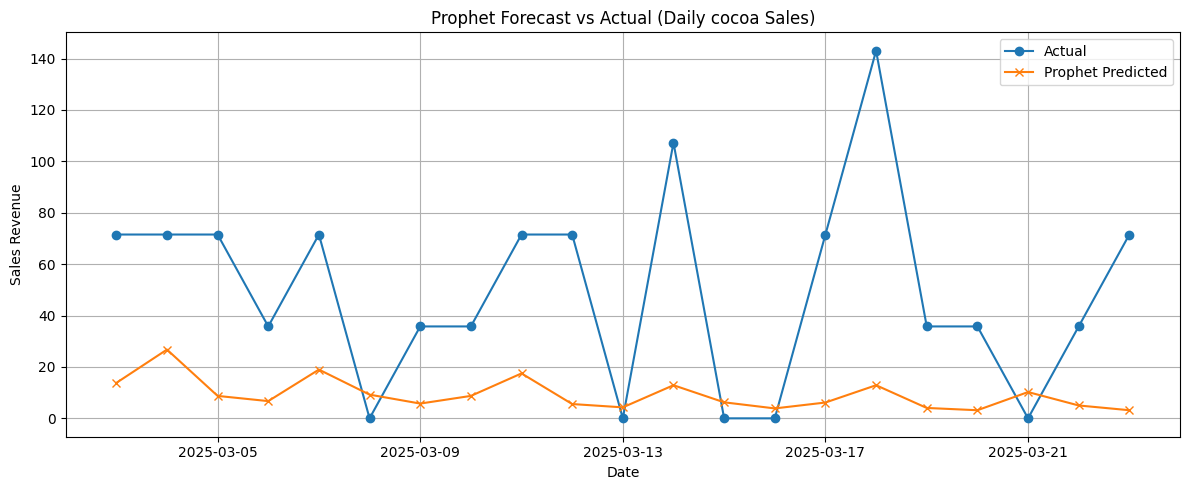

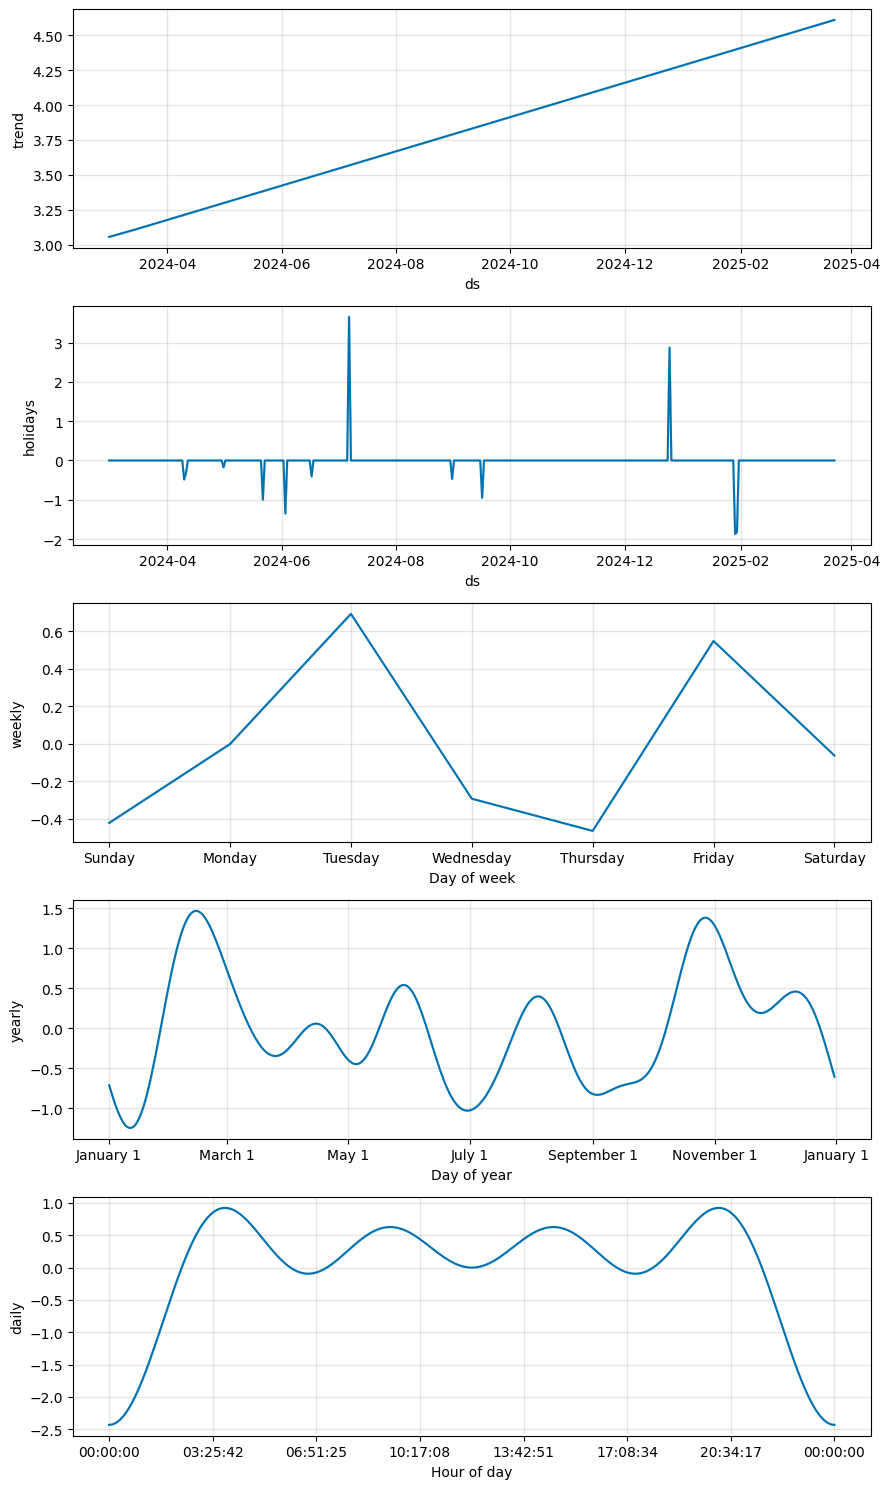

In [41]:
model_s('cocoa')  

### Cortado

17:52:00 - cmdstanpy - INFO - Chain [1] start processing
17:52:00 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 6.10
Daily Prophet RMSE: 7.95
Daily Prophet MAPE: 78.08%


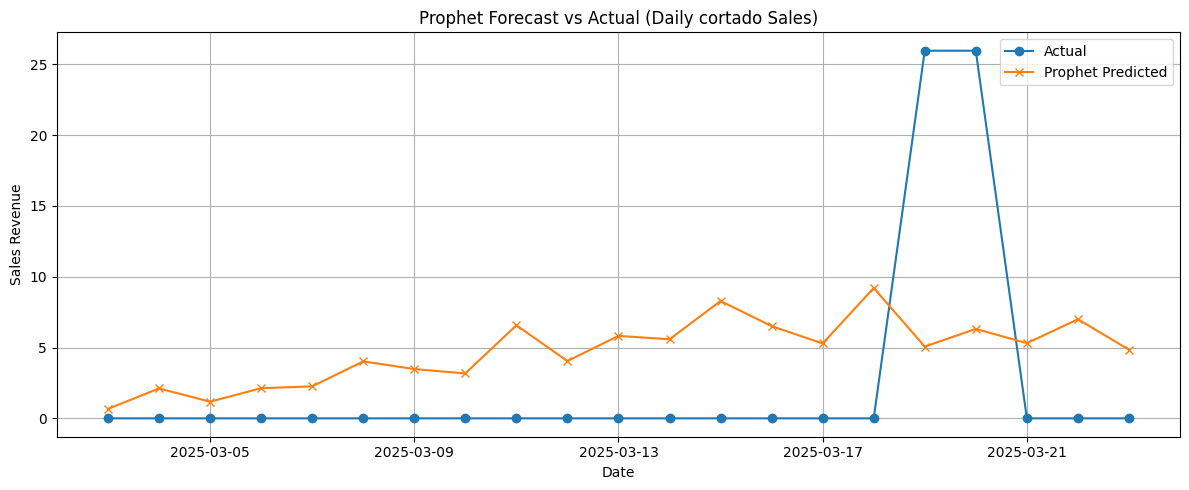

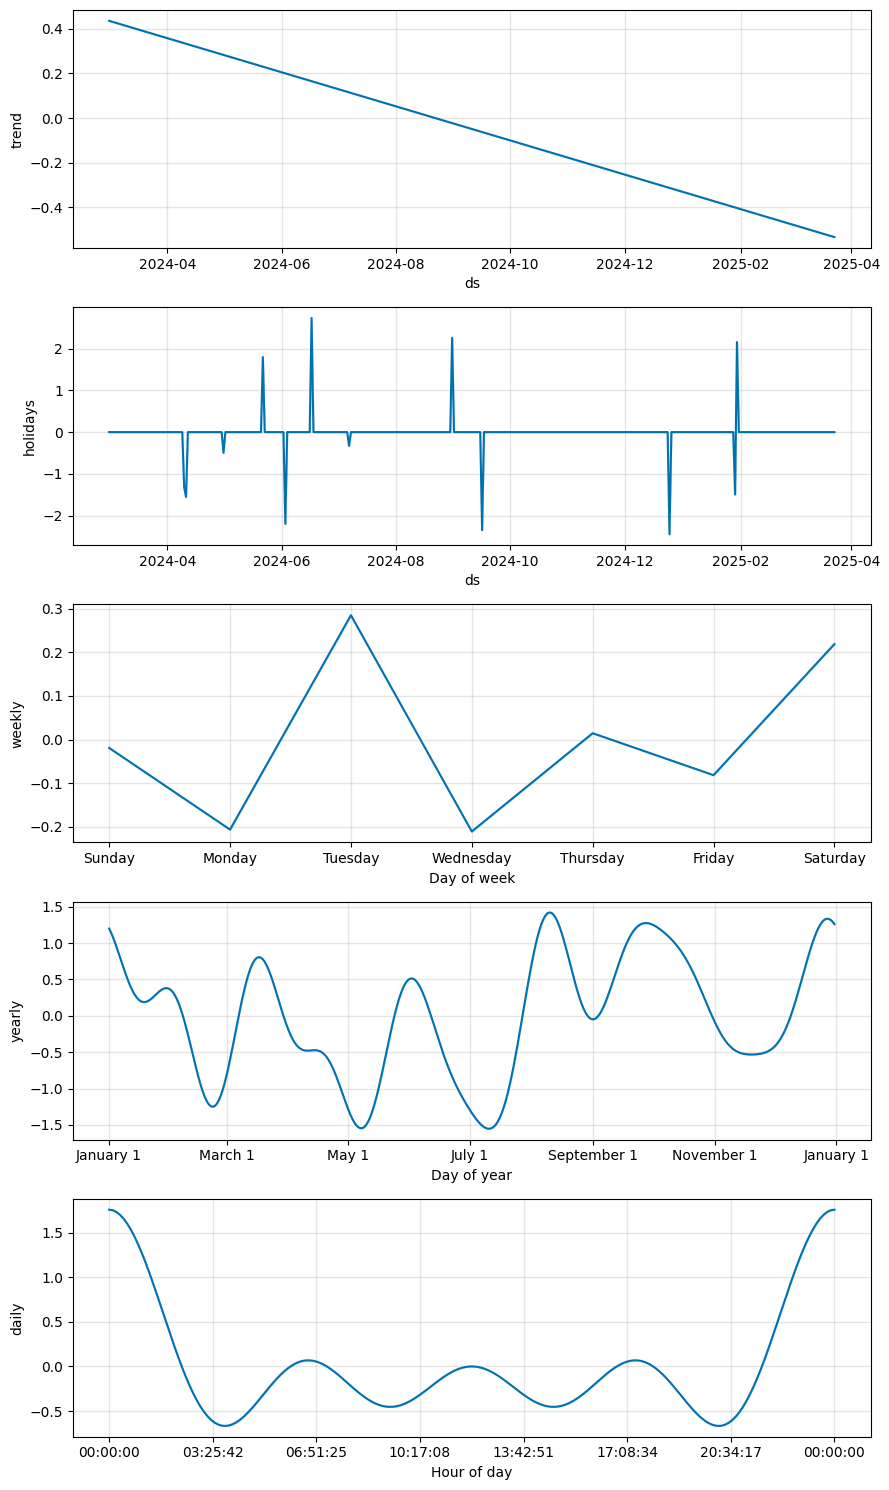

In [42]:
model_s('cortado')  

### Espresso

17:52:03 - cmdstanpy - INFO - Chain [1] start processing
17:52:03 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 13.29
Daily Prophet RMSE: 16.53
Daily Prophet MAPE: 73.59%


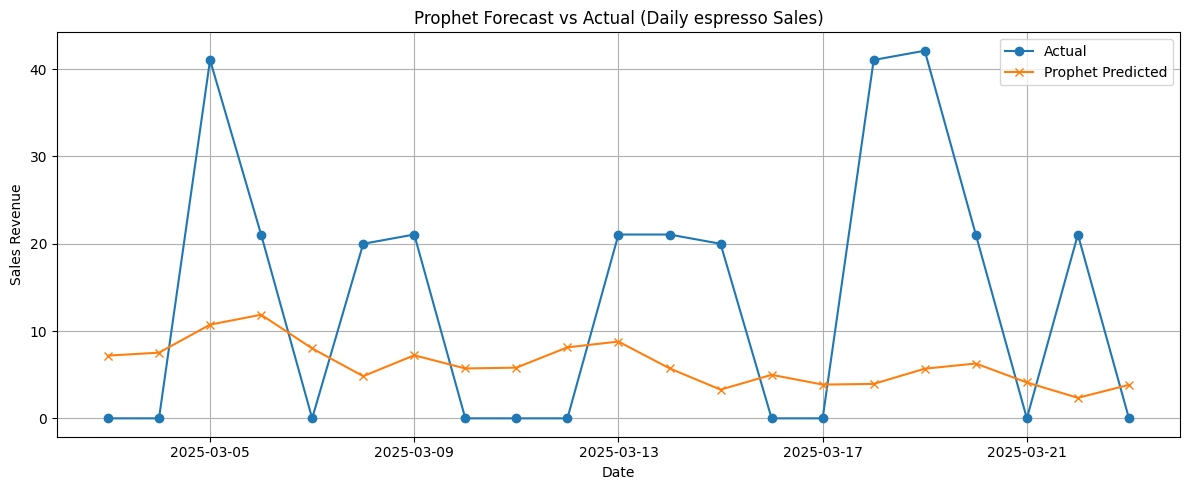

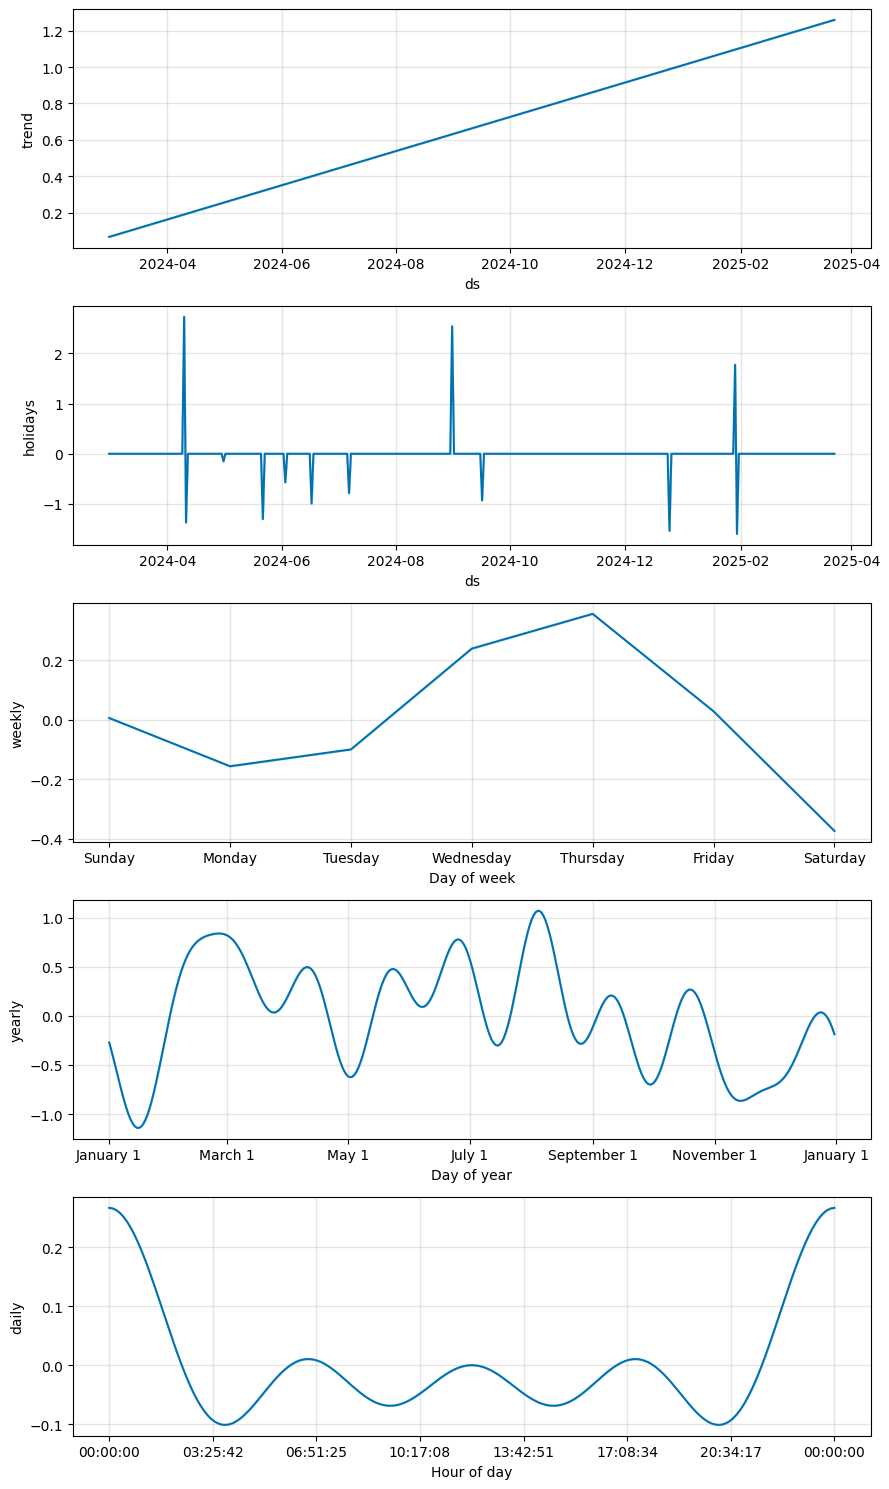

In [43]:
model_s('espresso') 

### Hot Chocolate

17:52:06 - cmdstanpy - INFO - Chain [1] start processing
17:52:06 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 39.13
Daily Prophet RMSE: 59.65
Daily Prophet MAPE: 99.59%


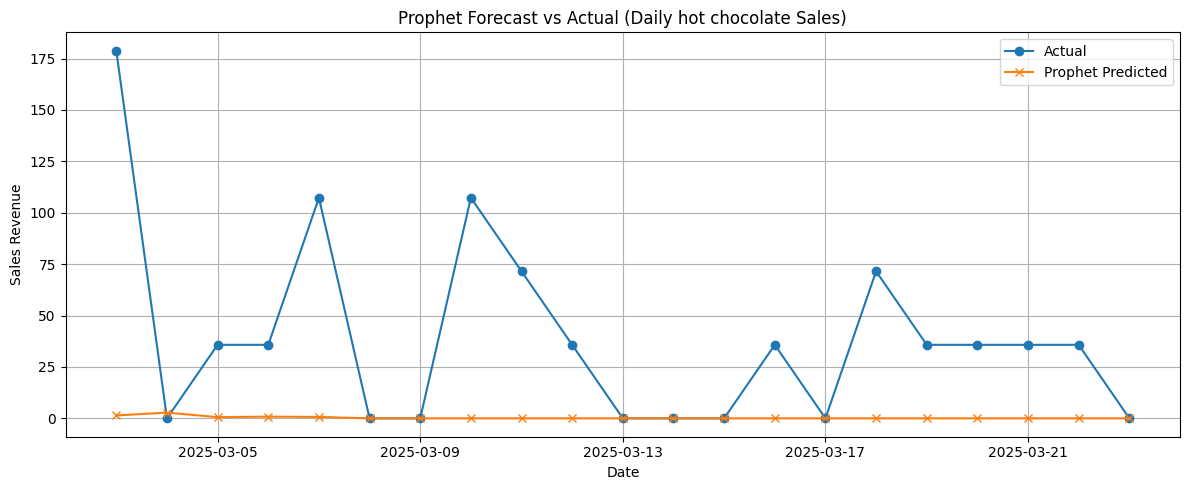

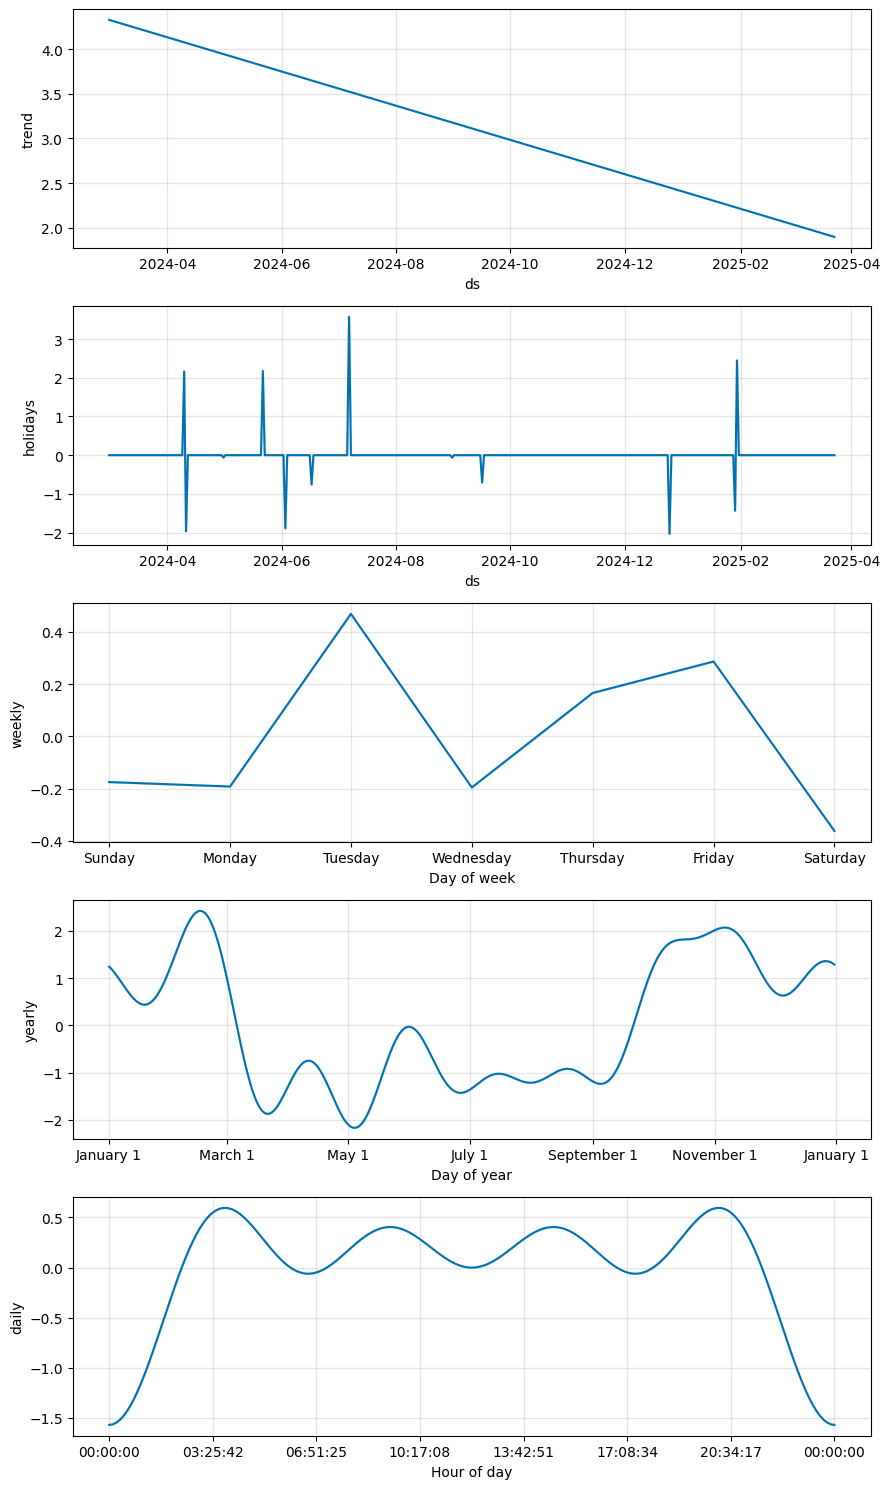

In [44]:
model_s('hot chocolate')  

### Irish Whiskey

17:52:09 - cmdstanpy - INFO - Chain [1] start processing
17:52:09 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 18.98
Daily Prophet RMSE: 27.41
Daily Prophet MAPE: 92.49%


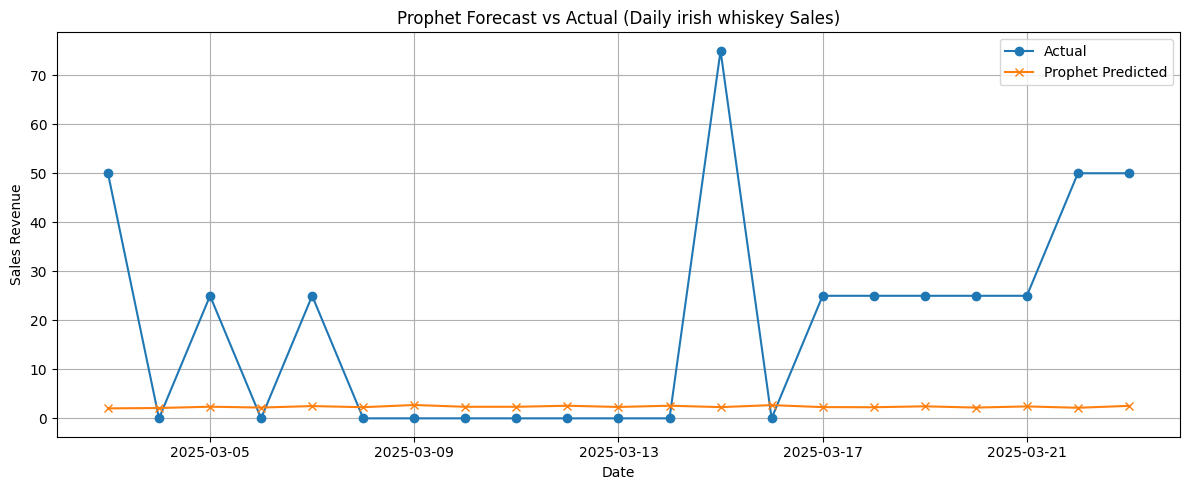

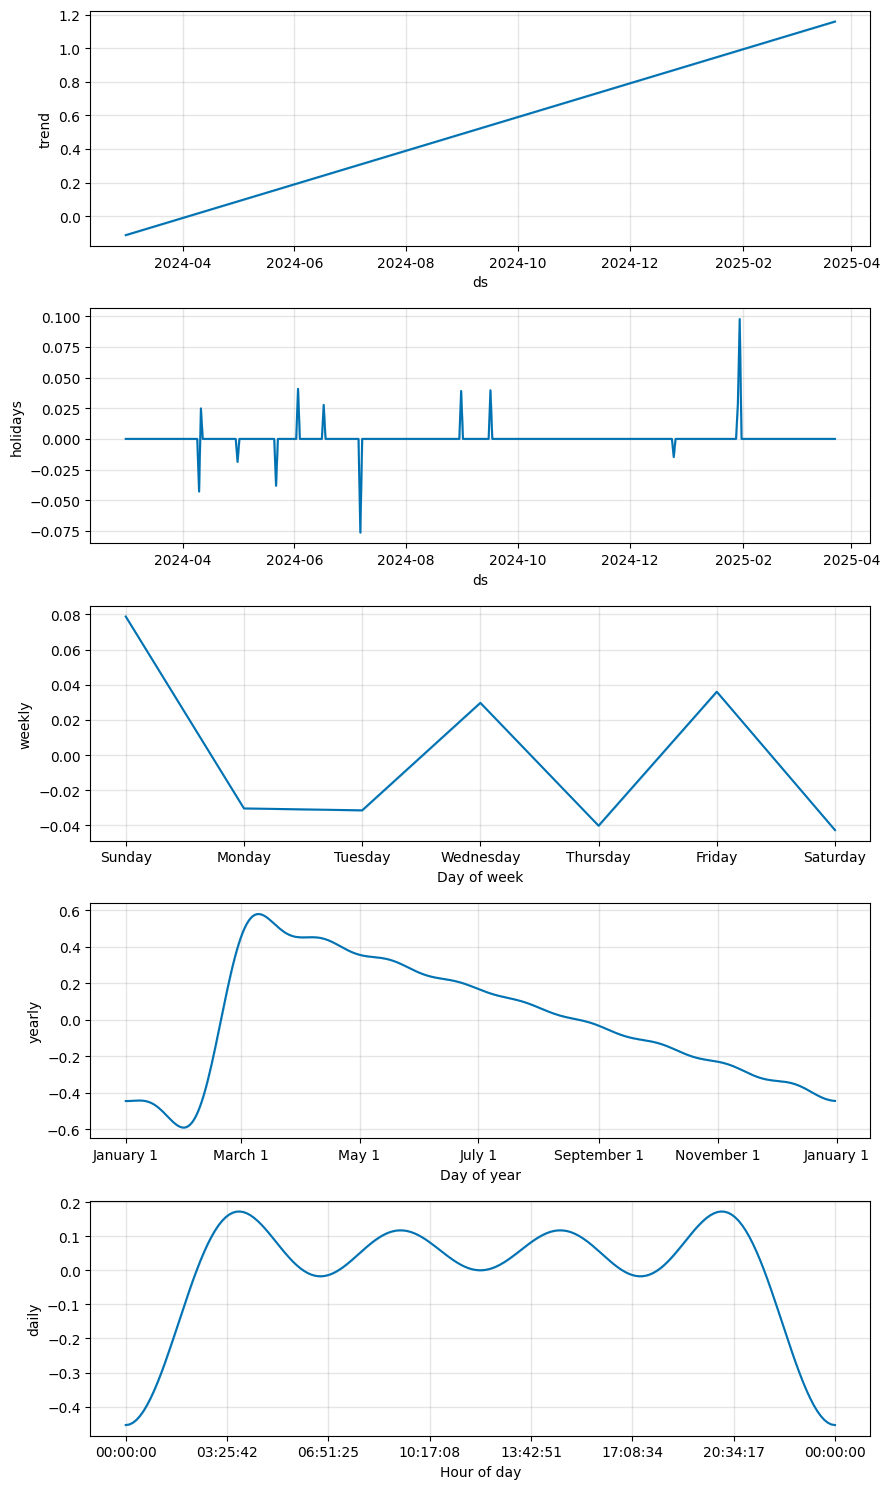

In [45]:
model_s('irish whiskey')  

### Latte

17:52:12 - cmdstanpy - INFO - Chain [1] start processing
17:52:12 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 72.80
Daily Prophet RMSE: 95.59
Daily Prophet MAPE: 55.54%


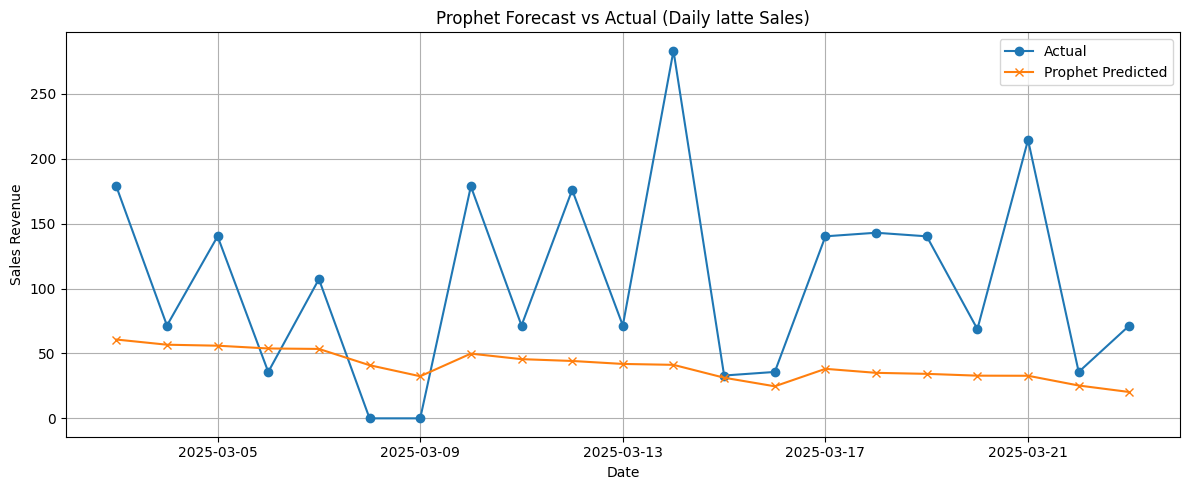

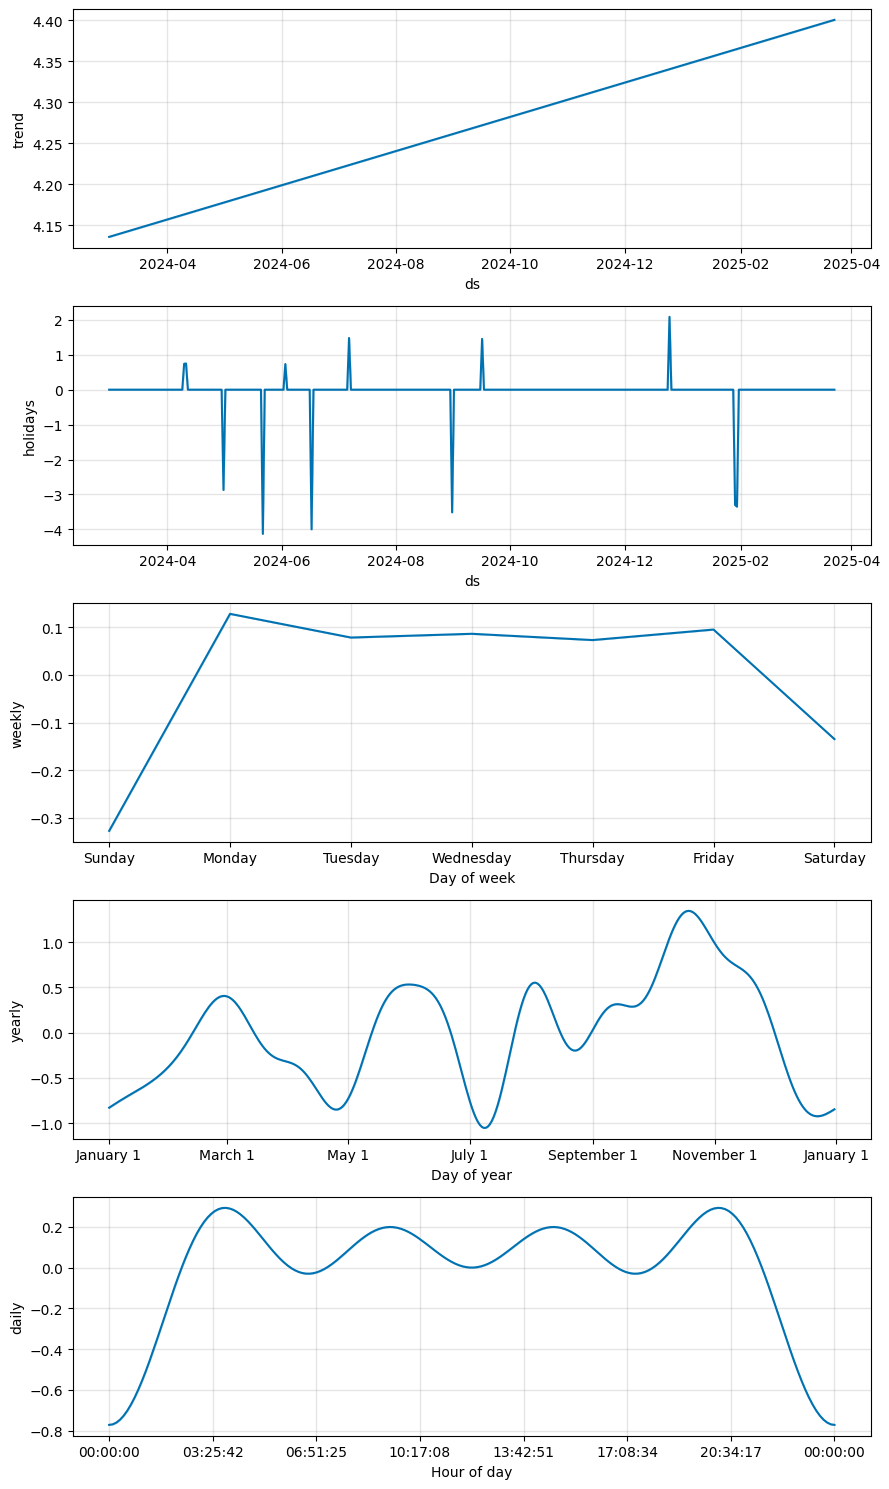

In [46]:
model_s('latte')  